In [1]:
%matplotlib inline

# Third party packages
import h5py
import numpy as np
import matplotlib as mpl
from matplotlib import rcParams
from matplotlib.lines import Line2D
import matplotlib.patches
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import cm
import glob
import json
from scipy.stats import gaussian_kde
import sys
import pandas as pd
import deepdish as dd

rcParams["text.usetex"] = True
rcParams["font.serif"] = "Computer Modern"
rcParams["font.family"] = "Serif"
rcParams["xtick.labelsize"]=14
rcParams["ytick.labelsize"]=14
rcParams["xtick.direction"]="in"
rcParams["ytick.direction"]="in"
rcParams["legend.fontsize"]=15
rcParams["axes.labelsize"]=16
rcParams["axes.grid"] = True
rcParams["grid.color"] = 'black'
rcParams["grid.linewidth"] = 1.
rcParams["grid.alpha"] = 0.6

In [2]:
color_truncated = "#08306b"
color_broken = "#4d9221"
color_plpeak = "#1f78b4"
color_multipeak = "#e31a1c"
color_multispin = '#ff7f00'

In [3]:
# This is a helper function to prepare data for KDE'ing
# Given initial x- and y- data points, this function will reflect the data all eight times across
# the prior boundaries in order to mitigate edge effects in the KDE
def mirrorData(ref_data_x,ref_data_y,x_priors,y_priors):
    
    low_x,high_x = x_priors
    low_y,high_y = y_priors
        
    # Original data
    data_x = np.copy(ref_data_x)
    data_y = np.copy(ref_data_y)
    data_x_mirrored = np.copy(data_x)
    data_y_mirrored = np.copy(data_y)
    
    # Left
    data_x_mirrored = np.append(data_x_mirrored,low_x-(data_x-low_x))
    data_y_mirrored = np.append(data_y_mirrored,data_y)
    
    # Right
    data_x_mirrored = np.append(data_x_mirrored,high_x+(high_x-data_x))
    data_y_mirrored = np.append(data_y_mirrored,data_y)   
    
    # Top
    data_x_mirrored = np.append(data_x_mirrored,data_x)
    data_y_mirrored = np.append(data_y_mirrored,high_y+(high_y-data_y))
    
    # Bottom
    data_x_mirrored = np.append(data_x_mirrored,data_x)
    data_y_mirrored = np.append(data_y_mirrored,low_y-(data_y-low_y))
    
    # Upper left
    data_x_mirrored = np.append(data_x_mirrored,low_x-(data_x-low_x))
    data_y_mirrored = np.append(data_y_mirrored,high_y+(high_y-data_y))

    # Lower left
    data_x_mirrored = np.append(data_x_mirrored,low_x-(data_x-low_x))
    data_y_mirrored = np.append(data_y_mirrored,low_y-(data_y-low_y))

    # Upper right
    data_x_mirrored = np.append(data_x_mirrored,high_x+(high_x-data_x))
    data_y_mirrored = np.append(data_y_mirrored,high_y+(high_y-data_y))

    # Lower right
    data_x_mirrored = np.append(data_x_mirrored,high_x+(high_x-data_x))
    data_y_mirrored = np.append(data_y_mirrored,low_y-(data_y-low_y))
    
    return data_x_mirrored,data_y_mirrored

# Another helper function to obtain 90% credible bounds from a list of samples
# Invoked by plot_corner to create labels on 1D posteriors
def getBounds(data):
    
    # Transform to a numpy arry
    data = np.array(data)

    # Get median, 5% and 95% quantiles
    med = np.median(data)
    upperLim = np.sort(data)[int(0.95*data.size)]
    lowerLim = np.sort(data)[int(0.05*data.size)]
 
    # Turn quantiles into upper and lower uncertainties
    upperError = upperLim-med
    lowerError = med-lowerLim
    
    return med,upperError,lowerError
    
def plot_corner(fig,plot_data,color,hist_alpha=0.7,bins=20,mirror=True,kdewidth=1.):
    
    # Input variable plot_data should be a dictionary whose keys are the individual variables to plot.
    # Each key should, in turn, link to another nested dictionary with the following keys:
    # - "data" : Actual data values
    # - "plot_bounds" : Tuple of min/max values to display on plot
    # - "label" : Latex string for figure labeling
    # - "priors" : Tuple of min/max prior bounds

    # Define a linear color map
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",color])
    
    # Loop across dimensions that we want to plot
    keys = list(plot_data)    
    ndim = len(keys)
    for i,key in enumerate(keys):
       
        # Plot the marginal 1D posterior (i.e. top of a corner plot column)
        ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
        ax.set_rasterization_zorder(1)
        
        ax.hist(plot_data[key]['data'],bins=np.linspace(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1],bins),\
               rasterized=True,color=color,alpha=hist_alpha,density=True,zorder=0)
        ax.hist(plot_data[key]['data'],bins=np.linspace(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1],bins),\
                histtype='step',color='black',density=True,zorder=2)
        ax.grid(True,dashes=(1,3))
        ax.set_xlim(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1])
        ax.set_title(r"${0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(*getBounds(plot_data[key]['data'])),fontsize=14)

        # Turn off tick labels if this isn't the first dimension
        if i!=0:
            ax.set_yticklabels([])

        # If this is the last dimension add an x-axis label
        if i==ndim-1:
            ax.set_xlabel(plot_data[key]['label'])
            
        # If not the last dimension, loop across other variables and fill in the rest of the column with 2D plots
        else:
            
            ax.set_xticklabels([])
            for j,k in enumerate(keys[i+1:]):
                
                # Make a 2D density plot
                ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))
                ax.set_rasterization_zorder(1)
                
                ax.hexbin(plot_data[key]['data'],plot_data[k]['data'],cmap=cmap,mincnt=1,gridsize=bins,\
                         extent=(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1],plot_data[k]['plot_bounds'][0],plot_data[k]['plot_bounds'][1]),
                         linewidths=(0,),zorder=0)

                # The rest of this "for" loop involves code to additionally add contours.
                # First, reflect data across all boundaries to have reasonable edge conditions
                if mirror:
                    mirrored_x,mirrored_y = mirrorData(plot_data[key]['data'],plot_data[k]['data'],plot_data[key]['priors'],plot_data[k]['priors'])            
                else:
                    mirrored_x = plot_data[key]['data']
                    mirrored_y = plot_data[k]['data']                
                
                # In drawing contours, we'll also need to KDE the data
                # Different dimensions will naturally want different KDE bandwidths.
                # To get reasonable-looking contours, reach a "compromise" between the two dimensions in question
                kde_width1 = np.std(plot_data[key]['data'])*np.power(float(len(plot_data[key]['data'])),-1./6.)/np.std(mirrored_x)
                kde_width2 = np.std(plot_data[k]['data'])*np.power(float(len(plot_data[k]['data'])),-1./6.)/np.std(mirrored_y)
                kde_width = kdewidth*np.sqrt(kde_width1*kde_width2)                
                print(key,k,kde_width)
                kde = gaussian_kde([mirrored_x,mirrored_y],bw_method=kde_width)

                # Make a regular grid and evaluate the KDE
                x_gridpoints = np.linspace(plot_data[key]['priors'][0],plot_data[key]['priors'][1],60)
                y_gridpoints = np.linspace(plot_data[k]['priors'][0],plot_data[k]['priors'][1],59)
                x_grid,y_grid = np.meshgrid(x_gridpoints,y_gridpoints)
                z_grid = kde([x_grid.reshape(-1),y_grid.reshape(-1)]).reshape(y_gridpoints.size,x_gridpoints.size)

                # Find the probabilities corresponding to central 50% and 90% probabilities
                sortedVals = np.sort(z_grid.flatten())[::-1]
                cdfVals = np.cumsum(sortedVals)/np.sum(sortedVals)
                i50 = np.argmin(np.abs(cdfVals - 0.50))
                i90 = np.argmin(np.abs(cdfVals - 0.90))
                val50 = sortedVals[i50]
                val90 = sortedVals[i90]
                
                # Draw contours
                CS = ax.contour(x_gridpoints,y_gridpoints,z_grid,levels=(val90,val50),linestyles=('dashed','solid'),colors='k',linewidths=1,zorder=2)
                
                # Set plot bounds
                ax.set_xlim(plot_data[key]['plot_bounds'][0],plot_data[key]['plot_bounds'][1])
                ax.set_ylim(plot_data[k]['plot_bounds'][0],plot_data[k]['plot_bounds'][1])
                ax.grid(True,dashes=(1,3))
                
                # If still in the first column, add a y-axis label
                if i==0:
                    ax.set_ylabel(plot_data[k]['label'])
                else:
                    ax.set_yticklabels([])
               
                # If on the last row, add an x-axis label
                if j==ndim-i-2:
                    ax.set_xlabel(plot_data[key]['label'])
                else:
                    ax.set_xticklabels([])
                    
    plt.tight_layout()    
    return fig

---
## Figure 2: mMax distribution under Truncated model

This requires data from the O2 paper, copied into the Figure 2 directory, data from Population_Samples, and data from the PE sample release, found here: https://dcc.ligo.org/LIGO-P2000223/public

In [13]:
# Load O1+O2 mass distribution results
chain_ModelB_O2 = {}
with h5py.File('./Fig-2-mMax/O2_public_data_release/figure_data/corner_AB.h5') as inp:
    chain_ModelB_O2['mmin'] = np.array(inp['model_b']['m_min'])
    chain_ModelB_O2['mmax'] = np.array(inp['model_b']['m_max'])
    chain_ModelB_O2['alpha'] = np.array(inp['model_b']['alpha_m'])
    chain_ModelB_O2['mmin2'] = np.array(inp['model_b']['m_min'])
    chain_ModelB_O2['beta'] = np.array(inp['model_b']['beta_q'])
    
# Load O3a results, excluding 190521
fname = '../Population_Samples/no_190521/o1o2o3_mass_b_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json'
with open(fname) as f:
    jf = json.load(f)
    O3_posterior_samples_no190521 = jf['posterior']['content']

# Load full O3a results
fname = '../Population_Samples/default/o1o2o3_mass_b_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json'
with open(fname) as f:
    jf = json.load(f)
    O3_posterior_samples = jf['posterior']['content']   

/opt/ligo-py/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  app.launch_new_instance()


In [18]:
# Load in json file with mapping between GW names and S names
with open('./Fig-2-mMax/names.json','r') as jf:
    mappings = json.load(jf)
    GW_to_S_name = mappings['SNAME']
    GW_to_catalog_name = mappings['NNAME']

dict_keys(['GW190930A', 'GW190929A', 'GW190924A', 'GW190915A', 'GW190910A', 'GW190909A', 'GW190828B', 'GW190828A', 'GW190814A', 'GW190803A', 'GW190731A', 'GW190728A', 'GW190727A', 'GW190720A', 'GW190719A', 'GW190708A', 'GW190707A', 'GW190706A', 'GW190701A', 'GW190630A', 'GW190620A', 'GW190602A', 'GW190527A', 'GW190521B', 'GW190521A', 'GW190519A', 'GW190517A', 'GW190514A', 'GW190513A', 'GW190512A', 'GW190503A', 'GW190426A', 'GW190425A', 'GW190424A', 'GW190421A', 'GW190413B', 'GW190413A', 'GW190412A', 'GW190408A'])


1.0 GW190602A 50.49415758953568
2.0 GW190521A 69.02777172831324
3.0 GW190519A 45.83330141920791
Could not load: GW190425A


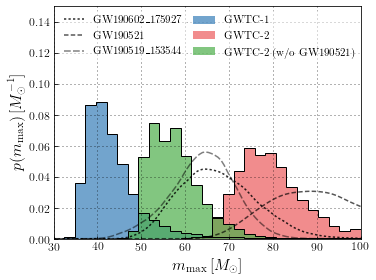

In [54]:
# Plotting bounds
x_min=30
x_max=100
y_min = 0.
y_max = 0.15

fig,ax = plt.subplots(figsize=(5.33,4))

# Histogram the posterior on m_max from O2
# The repeated commands are to get a filled histogram with a solid black border
ax.hist(chain_ModelB_O2['mmax'],label='GWTC-1',density=True,histtype='stepfilled',bins=np.linspace(x_min,x_max,30),alpha=0.7,color='#377eb8')
ax.hist(chain_ModelB_O2['mmax'],density=True,histtype='step',color='black',bins=np.linspace(x_min,x_max,30))

# Histogram O3 results
ax.hist(O3_posterior_samples['mmax'],label='GWTC-2',density=True,histtype='stepfilled',bins=np.linspace(x_min,x_max,30),alpha=0.5,color='#e41a1c')
ax.hist(O3_posterior_samples['mmax'],density=True,histtype='step',color='black',bins=np.linspace(x_min,x_max,30))

# Histogram O3 results w/out 190521
ax.hist(O3_posterior_samples_no190521['mmax'],label='GWTC-2 (w/o GW190521)',density=True,histtype='stepfilled',bins=np.linspace(x_min,x_max,30),alpha=0.7,color='#4daf4a')
ax.hist(O3_posterior_samples_no190521['mmax'],density=True,histtype='step',color='black',bins=np.linspace(x_min,x_max,30))

# Now loop across individual events and look for high mass events
# j is a helper variable that will help us set linestyles to distinguish individual events
j = 1.
legend_labels = []
for event in GW_to_catalog_name.keys():

    # Load data: change this filepath to point to your download from https://dcc.ligo.org/LIGO-P2000223/public 
    try:
        h5 = "/home/john.veitch/o3a_catalog_events/o3a_pe_samples_release/{0}.h5".format(event)
        f = h5py.File(h5,'r')
        BBH_post_samples = f['PrecessingSpinIMRHM']['posterior_samples']
        m1_SF = np.squeeze(BBH_post_samples['mass_1_source'])
    except KeyError:
        print("Could not load: {0}".format(event))
        
    # Get the 1% quantile for this single event's primary mass posterior
    m_1percent = np.quantile(m1_SF,0.01)
    
    # If m_1%>45 (that is, m1>45 at >99% credibility)...
    if m_1percent>45.:
        
        print(j,event,m_1percent)
        
        # KDE and plot this events primary mass posterior
        # Note that j sets the linestyle alpha and dashing style
        m1_kde = gaussian_kde(m1_SF)
        ax.plot(np.linspace(x_min,x_max,100),m1_kde(np.linspace(x_min,x_max,100)),color='black',\
               alpha = 1.-j/6., dashes=(1.5*j,1.5))
        
        # Save event name, will later be used to build a legend
        legend_labels.append(GW_to_catalog_name[event].replace("_","\_"))
        j += 1.

# Misc plot formatting
ax.grid(True,dashes=(1,3))
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)
ax.set_xlabel(r'$m_\mathrm{max}\,[M_\odot]$')
ax.set_ylabel(r'$p(m_\mathrm{max})\,[M_\odot^{-1}]$')
ax.tick_params(labelsize=12)

# Primary legend explaining the different histogram colors
legend1 = plt.legend(loc=(0.44,0.76),fontsize=11,framealpha=0.5)
legend1.get_frame().set_linewidth(0.0)

# Build a secondary legend that labels the different individual m1 posteriors
lines = ax.get_lines()
legend2 = plt.legend(lines,legend_labels,loc=(0.02,0.765),fontsize=11,framealpha=0.5,handlelength=1.8)
legend2.get_frame().set_linewidth(0.0)
ax.add_artist(legend1)

plt.tight_layout()
plt.savefig('Production-Figures/m_max.pdf',bbox_inches='tight')
plt.show()

---
## Fig 3: PPD for all mass models

In [7]:
# For use below, we'll want posteriors on the locations of the extra "features" build into the Broken Power Law,
# Power Law+Peak, and Multi-Peak models.

bpl_file = "../Population_Samples/default/o1o2o3_mass_d_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json"
plpeak_file = "../Population_Samples/default/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json"
multi_file = "../Population_Samples/default/o1o2o3_mass_e_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json"

# First get posterior on break point between two power laws
with open(bpl_file,"r") as jfile:
    bpl_jf = json.load(jfile)
    
posterior_samples_bpl = bpl_jf['posterior']['content']
mmin = np.array(posterior_samples_bpl['mmin'])
mmax = np.array(posterior_samples_bpl['mmax'])
b = np.array(posterior_samples_bpl['break_fraction'])

# See e.g. Appendix 7.3
m_break = mmin+b*(mmax-mmin)
m_break_05 = np.quantile(m_break,0.05)
m_break_95 = np.quantile(m_break,0.95)

# Get the posterior on the location of the Gaussian peak of Power Law + Peak
with open(plpeak_file,"r") as jfile:
    plpeak_jf = json.load(jfile)
    
posterior_samples_plpeak = plpeak_jf['posterior']['content']
peak_plp = posterior_samples_plpeak['mpp']
peak_plp_05 = np.quantile(peak_plp,0.05)
peak_plp_95 = np.quantile(peak_plp,0.95)

# Get posterior on the lower peak location of multi-peak
with open(multi_file,"r") as jfile:
    mpeak_jf = json.load(jfile)
    
posterior_samples_mpeak = mpeak_jf['posterior']['content']
peak_mp = posterior_samples_mpeak['mpp_1']
peak_mp_05 = np.quantile(peak_mp,0.05)
peak_mp_95 = np.quantile(peak_mp,0.95)

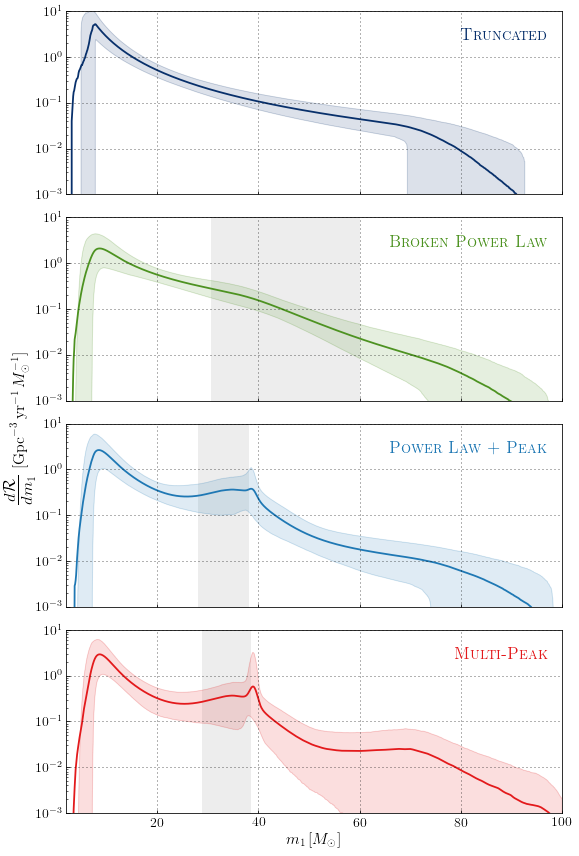

In [8]:
colours = [color_truncated,
           color_broken,
           color_plpeak,
           color_multipeak]

labels = [r"\textsc{Truncated}",
          r"\textsc{Broken Power Law}",
          r"\textsc{Power Law + Peak}",
          r"\textsc{Multi-Peak}"]

filenames = ["Multiple-Fig-Data/mass_ppd/default/o1o2o3_mass_b_iid_mag_two_comp_iid_tilt_powerlaw_redshift_mass_data.h5",
             "Multiple-Fig-Data/mass_ppd/default/o1o2o3_mass_d_iid_mag_two_comp_iid_tilt_powerlaw_redshift_mass_data.h5",
             "Multiple-Fig-Data/mass_ppd/default/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_mass_data.h5",
             "Multiple-Fig-Data/mass_ppd/default/o1o2o3_mass_e_iid_mag_two_comp_iid_tilt_powerlaw_redshift_mass_data.h5"]

# Initialize figure
fig = plt.figure(figsize=(8,12))

# Initialize arrays of masses and mass ratios at which data will be defined
# RECOMMENDED: Have these arrays be built into data input files, rather than coded by hand
mass_1 = np.linspace(3, 100, 1000)
mass_ratio = np.linspace(0.1, 1, 500)

# Loop across mass model files
for i,ff in enumerate(filenames):
    
    ax = fig.add_subplot('41{0}'.format(int(i+1)))    
    with h5py.File("{0}".format(ff),"r") as f:
        
        # Load mass distribution data
        # "ppd" : A 2D PPD in m1 vs. q space
        # "lines" : A collection of individual m1 and q population distributions
        mass_ppd = f["ppd"]
        mass_lines = f["lines"]
        
        # Integrate the 2D PPD over mass ratio to get marginal m1 PPD
        mass_1_ppd = np.trapz(mass_ppd, mass_ratio, axis=0)
        
        # Get 0.05 and 0.95 percentiles at each m1
        mass_1_lower = np.percentile(mass_lines["mass_1"], 5, axis=0)
        mass_1_upper = np.percentile(mass_lines["mass_1"], 95, axis=0)
    
    # Plot PPD and fill-between 90% intervals
    ax.plot(mass_1, mass_1_ppd, lw=1.8, color=colours[i], label=labels[i],zorder=1)
    ax.plot(mass_1, mass_1_lower,lw=0.2,color=colours[i],zorder=1,alpha=0.3)
    ax.plot(mass_1, mass_1_upper,lw=0.2,color=colours[i],zorder=1,alpha=0.3)
    plt.fill_between(mass_1, mass_1_lower, mass_1_upper, alpha=0.14, color=colours[i],zorder=0)
    
    # Add model label
    plt.text(0.97,0.9,labels[i],fontsize=16,transform=ax.transAxes,color=colours[i],ha='right', va='top')

    # Misc formatting
    ax.set_xlim(2.,100.)
    ax.set_yscale('log')
    ax.set_ylim(1e-3,10)
    ax.set_ylabel('.', color=(0, 0, 0, 0),fontsize=16 )
    ax.grid(True,dashes=(1,3))
    
    # Add vertical grey shading for "feature" location
    if i==1:
        ax.fill_betweenx([1e-5,1e5],m_break_05,m_break_95,zorder=-3,facecolor="#ebebeb",edgecolor='grey',alpha=0.9,linewidth=0)

    if i==2:
        ax.fill_betweenx([1e-5,1e5],peak_plp_05,peak_plp_95,zorder=-3,facecolor="#ebebeb",edgecolor='grey',alpha=0.9,linewidth=0)

    if i==3:
        ax.fill_betweenx([1e-5,1e5],peak_mp_05,peak_mp_95,zorder=-3,facecolor="#ebebeb",edgecolor='grey',alpha=0.9,linewidth=0)
        ax.set_xlabel(r"$m_{1}\,[M_{\odot}]$")
    
    else:
        ax.set_xticklabels([])
    
fig.text(0.0, 0.5, r"{\fontsize{24pt}{3em}$\frac{d\mathcal{R}}{dm_{1}}$} $[\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,M_{\odot}^{-1}]$", va='center', rotation='vertical',fontsize=16)    
    
plt.tight_layout()
plt.savefig('Production-Figures/m1_astro.pdf',bbox_inches='tight')
plt.show()

---
## Fig 4: Observed PPD for all mass models
#### Updated July 14, 2020

findfont: Font family ['Serif'] not found. Falling back to DejaVu Sans.


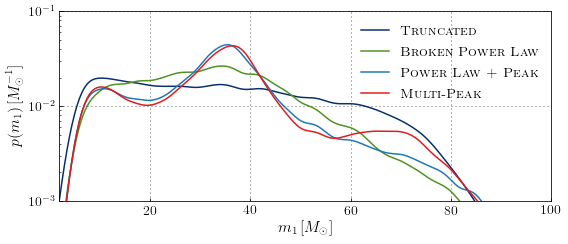

In [10]:
from scipy.stats import gaussian_kde

# Full output for various mass models
colours = [color_truncated,
           color_broken,
           color_plpeak,
           color_multipeak]
labels = [r"\textsc{Truncated}",
          r"\textsc{Broken Power Law}",
          r"\textsc{Power Law + Peak}",
          r"\textsc{Multi-Peak}"]
full_datafiles = ["./Multiple-Fig-Data/synthetic_observed_samples/o1o2o3_mass_b_iid_mag_two_comp_iid_tilt_powerlaw_redshift_full_posterior.hdf5",
                  "./Multiple-Fig-Data/synthetic_observed_samples/o1o2o3_mass_d_iid_mag_two_comp_iid_tilt_powerlaw_redshift_full_posterior.hdf5",
                  "./Multiple-Fig-Data/synthetic_observed_samples/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_full_posterior.hdf5",
                  "./Multiple-Fig-Data/synthetic_observed_samples/o1o2o3_mass_e_iid_mag_two_comp_iid_tilt_powerlaw_redshift_full_posterior.hdf5"]

# Instantiate figure, loop across model data files
fig,ax = plt.subplots(figsize=(8,3.5))
for i,datafile in enumerate(full_datafiles):
    
    # Read out data from prepared h5 file
    # 'events': A list of GWTC-2 events
    # 'samples' : List of samples, including synthetic samples for mock events
    with h5py.File("{0}".format(datafile),'r') as ff:
        filedata = ff["samples"][:]
        events = [event.decode() for event in ff["events"]]
    data = pd.DataFrame()
    for name in filedata.dtype.names:
        data[name] = filedata[name]
    
    # Load synthetic observations
    n_events = len(events)
    synthetic = np.array([
            data[f"synthetic_mass_1_{ii}"] for ii in range(len(events))
            if f"synthetic_mass_1_{ii}" in data
            ])
    
    # Histogram
    masses = np.linspace(0.,100.,200)
    dpdm_kde = gaussian_kde(synthetic.flatten())  
    ax.plot(masses,dpdm_kde(masses),color=colours[i],lw=1.5,label=labels[i])

# Figure formatting
ax.set_xlim(2.,100.)
ax.set_yscale('log')
ax.set_ylim(1e-3,1e-1)
ax.grid(True,dashes=(1,3))
plt.legend(loc='upper right',frameon=False,fontsize=14)
ax.set_xlabel(r'$m_1\,[M_\odot]$')
ax.set_ylabel(r'$p(m_1)\,[M_\odot^{-1}]$')

plt.tight_layout()
plt.savefig('Production-Figures/m1_obs.pdf',bbox_inches='tight')
plt.show()

---
## Fig 5: Broken Power Law alpha1 vs. alpha2
#### Updated July 14, 2020

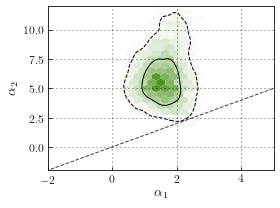

In [11]:
# Load posterior
with open("../Population_Samples/default/o1o2o3_mass_d_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json","r") as jfile:
    jf = json.load(jfile)

posterior_samples = jf['posterior']['content']    
alpha_1 = posterior_samples['alpha_1']
alpha_2 = posterior_samples['alpha_2']

# Plotting bounds
x_min = -2
x_max = 5.
y_min = -2
y_max = 12

# Create a linear colormap between white and the "Broken PL" model color
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",color_broken])

# Plot 2D alpha1 vs. alpha2 posterior
fig,ax = plt.subplots(figsize=(4,3))
ax.hexbin(alpha_1,alpha_2,cmap=cmap,gridsize=25,mincnt=1,extent=(x_min,x_max,y_min,y_max),linewidths=(0.,))

# The next chunk of code creates contours
# First construct a KDE and evaluate it on a grid across alpha1 vs. alpha2 space
kde = gaussian_kde([alpha_1,alpha_2])
x_gridpoints = np.linspace(x_min,x_max,60)
y_gridpoints = np.linspace(y_min,y_max,59)
x_grid,y_grid = np.meshgrid(x_gridpoints,y_gridpoints)
z_grid = kde([x_grid.reshape(-1),y_grid.reshape(-1)]).reshape(y_gridpoints.size,x_gridpoints.size)

# Sort the resulting z-values to get estimates of where to place 50% and 90% contours
sortedVals = np.sort(z_grid.flatten())[::-1]
cdfVals = np.cumsum(sortedVals)/np.sum(sortedVals)
i50 = np.argmin(np.abs(cdfVals - 0.50))
i90 = np.argmin(np.abs(cdfVals - 0.90))
val50 = sortedVals[i50]
val90 = sortedVals[i90]

# Draw contours at these locations
CS = ax.contour(x_gridpoints,y_gridpoints,z_grid,levels=(val90,val50),linestyles=('dashed','solid'),colors='k',linewidths=1)

# Draw a diagonal line for illustration purposes
ax.plot(np.arange(-3,13),np.arange(-3,13),lw=1,ls='--',color='black',alpha=0.75)

# Misc formatting
ax.grid(True,dashes=(1,3))
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)
ax.set_xlabel(r'$\alpha_1$',fontsize=14)
ax.set_ylabel(r'$\alpha_2$',fontsize=14)
ax.tick_params(labelsize=12)

plt.tight_layout()
fig.savefig('./Production-Figures/alpha1_alpha2.pdf',bbox_inches='tight')
plt.show()

---
## Fig 6: Gaussian fraction in Power Law + Peak Model
#### Updated Aug 4, 2020

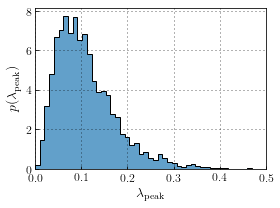

In [12]:
# Load Power Law + Peak samples
with open("../Population_Samples/default/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json","r") as jfile:
    jf = json.load(jfile)

posterior_samples = jf['posterior']['content']
lambdas = posterior_samples['lam']

# Figure bounds
x_min = 0.
x_max = 0.5

fig,ax = plt.subplots(figsize=(4,3))

# Histogram lambda
ax.hist(lambdas,bins=np.linspace(0.,0.5,50),histtype='stepfilled',color=color_plpeak,alpha=0.7,density=True)
ax.hist(lambdas,bins=np.linspace(0.,0.5,50),histtype='step',color='black',density=True)

# Misc formatting
ax.grid(True,dashes=(1,3))
ax.set_xlim(x_min,x_max)
ax.set_xlabel(r'$\lambda_\mathrm{peak}$',fontsize=14)
ax.set_ylabel(r'$p(\lambda_\mathrm{peak})$',fontsize=14)
ax.tick_params(labelsize=12)

plt.tight_layout()
fig.savefig('./Production-Figures/lambda_histogram.pdf',bbox_inches='tight')
plt.show()

---
## Fig 7: mMin vs. delta_m
#### Updated Aug 4, 2020

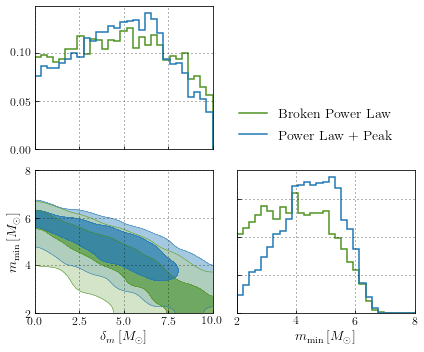

In [13]:
# Load broken power law posterior
with open("../Population_Samples/default/o1o2o3_mass_d_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json","r") as jfile:
    jf = json.load(jfile)
    posterior_samples = jf['posterior']['content'] 
    delta_m_bpl = posterior_samples['delta_m']
    mMin_bpl = posterior_samples['mmin']
    
# Load Power Law + Peak samples
with open("../Population_Samples/default/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json","r") as jfile:
    jf = json.load(jfile)
    posterior_samples = jf['posterior']['content']
    delta_m_plpeak = posterior_samples['delta_m']
    mMin_plpeak = posterior_samples['mmin']
    
# Create a linear colormap between white and the "Broken PL" model color
cmap_broken = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",color_broken])
cmap_plpeak = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white",color_plpeak])

# Plotting bounds
dm_min = 0
dm_max = 10.
mMin_min = 2
mMin_max = 8

fig = plt.figure(figsize=(6,5))

# Delta-m
ax = fig.add_subplot(2,2,1)
ax.hist(delta_m_bpl,density=True,histtype='step',bins=np.linspace(dm_min,dm_max,30),lw=1.5,color=color_broken)
ax.hist(delta_m_plpeak,density=True,histtype='step',bins=np.linspace(dm_min,dm_max,30),lw=1.5,color=color_plpeak)
ax.grid(True,dashes=(1,3))
ax.set_xticklabels([])
ax.set_xlim(dm_min,dm_max)
ax.tick_params(labelsize=12)

# mMin
ax = fig.add_subplot(2,2,4)
ax.hist(mMin_bpl,density=True,histtype='step',bins=np.linspace(mMin_min,mMin_max,30),lw=1.5,color=color_broken)
ax.hist(mMin_plpeak,density=True,histtype='step',bins=np.linspace(mMin_min,mMin_max,30),lw=1.5,color=color_plpeak)
ax.grid(True,dashes=(1,3))
ax.set_yticklabels([])
ax.set_xlim(mMin_min,mMin_max)
ax.set_xlabel(r'$m_\mathrm{min}\,[M_\odot]$',fontsize=14)
ax.tick_params(labelsize=12)

ax = fig.add_subplot(2,2,3)
ax.set_xlim(dm_min,dm_max)
ax.set_ylim(mMin_min,mMin_max)

# Reflect across all the boundaries
mirrored_delta_m_bpl,mirrored_mMin_bpl = mirrorData(delta_m_bpl,mMin_bpl,(0,10),(2,8))
mirrored_delta_m_plpeak,mirrored_mMin_plpeak = mirrorData(delta_m_plpeak,mMin_plpeak,(0,10),(2,8))

### Broken power law
# Proceed as usual -- get a geometric mean kde bin width
scott_bpl_x = len(delta_m_bpl)**(-1./6.)*np.std(delta_m_bpl)/np.std(mirrored_delta_m_bpl)
scott_bpl_y = len(mMin_bpl)**(-1./6.)*np.std(mMin_bpl)/np.std(mirrored_mMin_bpl)
scott_bpl = np.sqrt(scott_bpl_x*scott_bpl_y)

# KDE over our samples and evaluate on a grid
kde = gaussian_kde([mirrored_delta_m_bpl,mirrored_mMin_bpl],bw_method=scott_bpl)
x_gridpoints = np.linspace(dm_min,dm_max,60)
y_gridpoints = np.linspace(mMin_min,mMin_max,59)
x_grid,y_grid = np.meshgrid(x_gridpoints,y_gridpoints)
z_grid = kde([x_grid.reshape(-1),y_grid.reshape(-1)]).reshape(y_gridpoints.size,x_gridpoints.size)

# Sort the resulting z-values to get estimates of where to place 50% and 90% contours
sortedVals = np.sort(z_grid.flatten())[::-1]
cdfVals = np.cumsum(sortedVals)/np.sum(sortedVals)
i50 = np.argmin(np.abs(cdfVals - 0.50))
i90 = np.argmin(np.abs(cdfVals - 0.90))
val50 = sortedVals[i50]
val90 = sortedVals[i90]

### Now do the same thing for the power-law + peak model
scott_plpeak_x = len(delta_m_plpeak)**(-1./6.)*np.std(delta_m_plpeak)/np.std(mirrored_delta_m_plpeak)
scott_plpeak_y = len(mMin_plpeak)**(-1./6.)*np.std(mMin_plpeak)/np.std(mirrored_mMin_plpeak)
scott_plpeak = np.sqrt(scott_plpeak_x*scott_plpeak_y)
kde_plpeak = gaussian_kde([mirrored_delta_m_plpeak,mirrored_mMin_plpeak],bw_method=scott_plpeak)
z_grid_plpeak = kde_plpeak([x_grid.reshape(-1),y_grid.reshape(-1)]).reshape(y_gridpoints.size,x_gridpoints.size)
sortedVals_plpeak = np.sort(z_grid_plpeak.flatten())[::-1]
cdfVals_plpeak = np.cumsum(sortedVals_plpeak)/np.sum(sortedVals_plpeak)
i50_plpeak = np.argmin(np.abs(cdfVals_plpeak - 0.50))
i90_plpeak = np.argmin(np.abs(cdfVals_plpeak - 0.90))
val50_plpeak = sortedVals_plpeak[i50_plpeak]
val90_plpeak = sortedVals_plpeak[i90_plpeak]

ax.contourf(x_gridpoints,y_gridpoints,z_grid_plpeak,levels=(val90_plpeak,val50_plpeak),colors=cmap_plpeak((0.4,)),origin='lower')
ax.contourf(x_gridpoints,y_gridpoints,z_grid,levels=(val90,val50),alpha=0.6,colors=cmap_broken((0.4,)),origin='lower')
ax.contourf(x_gridpoints,y_gridpoints,z_grid,levels=(val50,np.max(z_grid)),alpha=0.75,colors=cmap_broken((0.9,)),origin='lower')
ax.contourf(x_gridpoints,y_gridpoints,z_grid_plpeak,levels=(val50_plpeak,np.max(z_grid_plpeak)),alpha=0.75,colors=cmap_plpeak((1.,)),origin='lower')

ax.contour(x_gridpoints,y_gridpoints,z_grid_plpeak,levels=(val90_plpeak,val50_plpeak),colors=color_plpeak,linewidths=0.5)
ax.contour(x_gridpoints,y_gridpoints,z_grid,levels=(val90,val50),colors=color_broken,linewidths=0.5)

# Misc formatting
ax.grid(True,dashes=(1,3))
ax.set_xlabel(r'$\delta_m\,[M_\odot]$',fontsize=14)
ax.set_ylabel(r'$m_\mathrm{min}\,[M_\odot]$',fontsize=14)
ax.tick_params(labelsize=12)

fig.legend([Line2D([0],[0],color=color_broken,lw=1.5),Line2D([0],[0],color=color_plpeak,lw=1.5)],\
           [r"Broken Power Law",r"Power Law + Peak"], loc=(0.55,0.58), fontsize=14,frameon=False,handlelength=2)

plt.tight_layout()
plt.savefig('./Production-Figures/dM_vs_mMin_corner.pdf',bbox_inches='tight')
plt.show()

---
## Fig 8a: Minimum mass distribution
#### Updated July 14, 2020

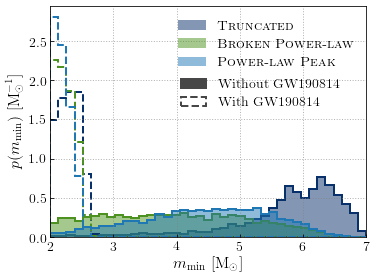

In [14]:
colours = ["#08306b",
           "#4d9221",
           "#1f78b4",
           "#08306b",
           "#4d9221",
           "#1f78b4"]
label = [r"\textsc{Truncated}",
         r"\textsc{Broken Power-law}",
         r"\textsc{Power-law Peak}",
         r"\textsc{Truncated} - includes GW190814",
         r"\textsc{Broken Power-law} - includes GW190814",
         r"\textsc{Power-law Peak} - includes GW190814"]

filenames = ["../Population_Samples/default/o1o2o3_mass_b_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json",
             "../Population_Samples/default/o1o2o3_mass_d_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json",
             "../Population_Samples/default/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json",
             "../Population_Samples/all_events/o1o2o3_mass_b_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json",
             "../Population_Samples/all_events/o1o2o3_mass_d_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json",
             "../Population_Samples/all_events/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json",
             ]

fig,ax = plt.subplots(figsize=(5.33,4))

i = 0
for ff in filenames:
    
    with open(ff,"r") as jfile:
        jf = json.load(jfile)
        posterior_samples = jf['posterior']['content'] 
        mmin = posterior_samples['mmin']
    
    if i < 3:
        
        linestyle='solid'
        alpha = 0.5
        histtype ='stepfilled'
        
        ax.hist(mmin, bins=np.linspace(2,7,40),label=label[i],density=True,linestyle=linestyle, color=colours[i], linewidth=2,histtype=histtype, alpha=alpha)
        ax.hist(mmin, bins=np.linspace(2,7,40),density=True,linestyle=linestyle, color=colours[i], linewidth=2,histtype='step')
        
    else:
        
        linestyle='dashed'
        histtype ='step'
        alpha=1.0
        
        ax.hist(mmin, bins=np.linspace(2,7,40),density=True,linestyle=linestyle, color=colours[i], linewidth=2,histtype=histtype, alpha=alpha)
    
    i +=1
    
# Define what will become the second legend (explaining the linestyles of line1 and line2)

handles = [Rectangle((0,0),1,1,color='#474747',fill=True,ls='solid',lw=2),
          Rectangle((0,0),1,1,color='#474747',fill=False,ls='dashed',lw=2)]
labels = ["Without GW190814","With GW190814"]
legend2 = plt.legend(handles,labels,fontsize=14,frameon=False,labelspacing=0.3,loc=(0.395,0.53),handlelength=1.85,handleheight=0.58)

# Save legend
ax.add_artist(legend2)
ax.legend(fontsize=14,frameon=False,labelspacing=0.3)

ax.set_xlabel("$m_\mathrm{min}$ [$\mathrm{M}_{\\odot}$]")
ax.set_ylabel("$p(m_\mathrm{min})$ [$\mathrm{M}_{\\odot}^{-1}$]")
ax.set_xlim(2,7)
ax.xaxis.grid(True,which='major',ls=':',color='grey')
ax.yaxis.grid(True,which='major',ls=':',color='grey')

plt.tight_layout()
plt.savefig('./Production-Figures/mMin_hist_comparison.pdf',bbox_inches='tight')


---
## Fig 8b: Effect of including/excluding 190814
#### Updated July 14, 2020

Plotting data from <HDF5 file "o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_mass_data.h5" (mode r)>
Plotting data from <HDF5 file "o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_mass_data.h5" (mode r)>


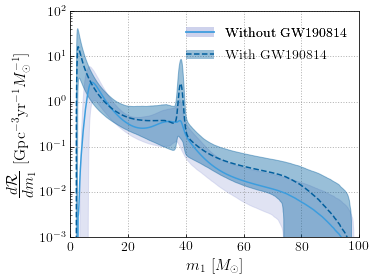

In [56]:
colours = ["#3c9dde","#025f9e","#b3b9e3"]

file_wout190814 = "Multiple-Fig-Data/mass_ppd/default/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_mass_data.h5"
file_w190814 = "Multiple-Fig-Data/mass_ppd/all_events/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_mass_data.h5"

limits = [5,95]
mass_1 = np.linspace(2, 100, 1000)
mass_ratio = np.linspace(0.1, 1, 500)

fig,ax = plt.subplots(figsize=(5.33,4))
    
with h5py.File(file_wout190814,"r") as f:

    # Load mass distribution data
    ppd = f["ppd"]
    lines = f["lines"]

    mass_1_ppd = np.trapz(ppd, mass_ratio, axis=0)
    mass_ratio_ppd = np.trapz(ppd, mass_1, axis=-1)

    print("Plotting data from {}".format(f))
    p1_wout190814, = ax.plot(mass_1, mass_1_ppd, color=colours[0], linestyle='solid',zorder=3)
    ax.fill_between(
        mass_1,
        np.percentile(lines["mass_1"], limits[0], axis=0),
        np.percentile(lines["mass_1"], limits[1], axis=0),
        color=colours[2],
        alpha=0.4,
        zorder=1
    )
    
with h5py.File(file_w190814,"r") as f:

    # Load mass distribution data
    ppd = f["ppd"]
    lines = f["lines"]

    mass_1_ppd = np.trapz(ppd, mass_ratio, axis=0)
    mass_ratio_ppd = np.trapz(ppd, mass_1, axis=-1)

    print("Plotting data from {}".format(f))
    p1_w190814, = ax.plot(mass_1, mass_1_ppd, color=colours[1], linestyle='dashed',zorder=4)
    ax.fill_between(
        mass_1,
        np.percentile(lines["mass_1"], limits[0], axis=0),
        np.percentile(lines["mass_1"], limits[1], axis=0),
        color=colours[1],
        alpha=0.4,
        zorder=2
    )

ax.set_xlim(0, 100)
ax.set_yscale('log')
ax.set_ylim(1e-3,1e2)

ax.xaxis.grid(True,which='major',ls=':',color='grey')
ax.yaxis.grid(True,which='major',ls=':',color='grey')

ax.set_xlabel("$m_{1}$ [$M_{\\odot}$]")

p2_wout190814 = Rectangle((0,0),1,1,color=colours[2], alpha=0.4, fill=True,linewidth=0)
p2_w190814 = Rectangle((0,0),1,1,color=colours[1], alpha=0.4, fill=True,linewidth=0)
leg1 = plt.legend(((p2_w190814,p1_w190814),),('With GW190814',),frameon=False,loc=(0.38,0.75),fontsize=14)
leg2 = plt.legend(((p2_wout190814,p1_wout190814),),('Without GW190814',),frameon=False,loc=(0.38,0.85),fontsize=14)

ax.add_artist(leg1)
ax.add_artist(leg2)

ylabel = r"{\fontsize{22pt}{3em}$\frac{d\mathcal{R}}{dm_{1}}$} [Gpc$^{-3}$yr$^{-1}M_{\odot}^{-1}$]"
ax.set_ylabel(ylabel)
plt.tight_layout()
plt.savefig('Production-Figures/mMin_ppd_comparison.pdf',bbox_inches='tight')


---
## Fig 9a: Chi-P Gaussian Corner Plot
#### Updated July 15, 2020

mu_p sigma_p 0.01209404969037297


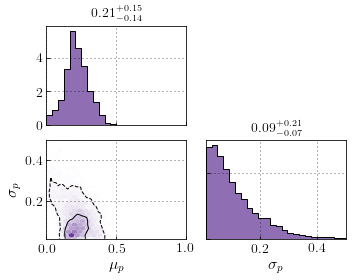

In [56]:
with open('./../Population_Samples/gaussian-spin/gaussian-chiEff-chiP-samples.json','r') as jf:
    data = json.load(jf)

plot_data = {
    'mu_p':{'data':data['mu_p'],'plot_bounds':(0.,1.),'priors':(0.,1.0),'label':r'$\mu_p$'},
    'sigma_p':{'data':data['sigma_p'],'plot_bounds':(0.01,0.5),'priors':(0.01,1.0),'label':r'$\sigma_p$'},
}

fig = plt.figure(figsize=(5,4))
plot_corner(fig,plot_data,"#6a3d9a",bins=25,hist_alpha=0.75,kdewidth=0.5)
plt.tight_layout()
fig.subplots_adjust(wspace=0.14, hspace=0.16)
fig.savefig('./Production-Figures/corner_chi_p.pdf',dpi=400,bbox_inches='tight')
plt.show()

---
## Fig 9b: Chi-P PDFs

In [17]:
# Load default spin data
default_data_file = './Multiple-Fig-Data/effective_spin_ppd/default-spin-xeff-xp-ppd-data.json'
with open(default_data_file,'r') as jf:
    default_data = json.load(jf)
default_chi_p_grid = np.array(default_data['chi_p_grid'])
default_chi_p_data = np.array(default_data['chi_p_pdfs']).T

# Load Gaussian model data
gaussian_data_file = "./Multiple-Fig-Data/effective_spin_ppd/gaussian-spin-xeff-xp-ppd-data.json"
with open(gaussian_data_file,'r') as jf:
    gaussian_data = json.load(jf)
gaussian_chi_p_grid = np.array(gaussian_data['chi_p_grid'])
gaussian_chi_p_data = np.array(gaussian_data['chi_p_pdfs'])

In [18]:
from scipy.special import erf
def calculate_Gaussian(x, mu, sigma2, low, high):
    norm = np.sqrt(sigma2*np.pi/2)*(-erf((low-mu)/np.sqrt(2*sigma2)) + erf((high-mu)/np.sqrt(2*sigma2)))
    y = (1.0/norm)*np.exp((-1.0*(x-mu)**2)/(2.*sigma2)) 
    return y

/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
findfont: Font family ['Serif'] not found. Falling back to DejaVu Sans.


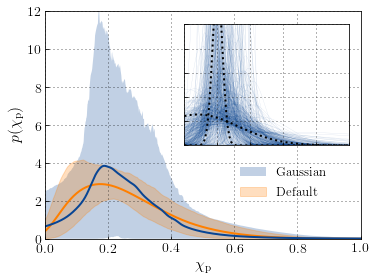

In [19]:
fig,ax = plt.subplots(figsize=(5.33,4))

ax.fill_between(gaussian_chi_p_grid,np.quantile(gaussian_chi_p_data,0.95,axis=0),
                np.quantile(gaussian_chi_p_data,0.05,axis=0),facecolor='#084594',alpha=0.25,label='Gaussian')
    
ax.fill_between(default_chi_p_grid,np.quantile(default_chi_p_data,0.95,axis=0),
                np.quantile(default_chi_p_data,0.05,axis=0), color='#ff7f00',alpha=0.25,label='Default')

ax.plot(default_chi_p_grid,np.mean(default_chi_p_data,axis=0),color='#ff7f00',lw=2)
ax.plot(gaussian_chi_p_grid,np.mean(gaussian_chi_p_data,axis=0),color='#084594',lw=2)

ax.set_xlim(0,1)
ax.set_ylim(0,12)
ax.grid(True,dashes=(1,3))
ax.set_xlabel(r'$\chi_\mathrm{p}$')
ax.set_ylabel(r'$p(\chi_\mathrm{p})$')
plt.legend(loc=(0.6,0.155),frameon=False,fontsize=13)

ax2 = fig.add_axes([0.49,0.48,0.43,0.42])
ax2.set_rasterization_zorder(1)
for i in range(gaussian_chi_p_data.shape[0]):
    ax2.plot(gaussian_chi_p_grid,gaussian_chi_p_data[i,:],lw=0.3,alpha=0.15,color='#084594',zorder=0)
    
ax2.plot(np.linspace(0,1,100),calculate_Gaussian(np.linspace(0,1,100),0.08,0.25**2.,0,1),color='black',lw=2,ls=':')
ax2.plot(np.linspace(0,1,100),calculate_Gaussian(np.linspace(0,1,100),0.2,0.03**2.,0,1),color='black',lw=2,ls=':')

ax2.set_xlim(0,1)
ax2.set_ylim(0,10)
ax2.grid(True,dashes=(1,3))
ax2.tick_params(labelsize=10)
ax2.tick_params(labelbottom=False,labelleft=False)   

plt.tight_layout()
plt.savefig('./Production-Figures/chi-p-modelComparison.pdf',bbox_inches='tight',dpi=200)

plt.show()

---
## Fig 10a: Default Spin Magnitude Distribution
#### Updated August 10, 2020

In [20]:
# Read data
f = h5py.File('./Fig-10-spin-Reconstruction/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_magnitude_data.h5','r')
ppd = f["ppd"]
lines = f["lines"]
spin_mags = np.linspace(0, 1, 1000)

# Normalize to get probability distributions on a1
normalized_lines = np.array([lines['a_1'][i,:]/np.trapz(lines['a_1'][i,:],spin_mags) for i in range(10000)])

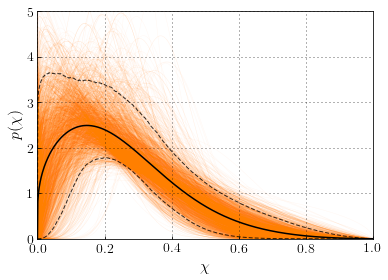

In [21]:
fig = plt.figure(figsize=(5.5,4.))
ax = fig.add_subplot()
ax.set_rasterization_zorder(1)

chosenSamples = np.random.choice(range(10000),size=3000)
for i in chosenSamples:
    ax.plot(spin_mags,normalized_lines[i,:],color="#ff7f00",lw=0.5,alpha=0.05,zorder=0)

spin_probs_05 = np.quantile(normalized_lines,0.05,axis=0)
spin_probs_95 = np.quantile(normalized_lines,0.95,axis=0)
spin_probs_ppd = np.mean(normalized_lines,axis=0)

ax.plot(spin_mags,spin_probs_05,color='black',dashes=(4,2),lw=1,alpha=0.8)
ax.plot(spin_mags,spin_probs_95,color='black',dashes=(4,2),lw=1,alpha=0.8)
ax.plot(spin_mags,spin_probs_ppd,color='black')
ax.set_xlim(0.,1.)
ax.set_ylim(0.,5)
ax.grid(True,dashes=(1,3))
ax.set_xlabel(r"$\chi$")
ax.set_ylabel(r"$p(\chi)$")

plt.tight_layout()
plt.savefig('./Production-Figures/component-spin-mag-ppd.pdf',bbox_inches='tight',dpi=200)
plt.show()

---
## Fig 10b: Default Spin Tilt Distribution
#### Updated August 10, 2020

In [22]:
# Read data
f = h5py.File('./Fig-10-spin-Reconstruction/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_orientation_data.h5','r')
ppd = f["ppd"]
lines = f["lines"]
cos_tilts = np.linspace(-1, 1, 1000)

# Normalize to get probability distributions on a1
normalized_lines = np.array([lines['cos_tilt_1'][i,:]/np.trapz(lines['cos_tilt_1'][i,:],cos_tilts) for i in range(10000)])

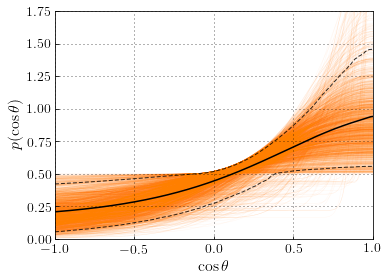

In [23]:
fig = plt.figure(figsize=(5.5,4.))
ax = fig.add_subplot()
ax.set_rasterization_zorder(1)

chosenSamples = np.random.choice(range(10000),size=3000)
for i in chosenSamples:
    ax.plot(cos_tilts,normalized_lines[i,:],color="#ff7f00",lw=0.5,alpha=0.05,zorder=0)

spin_probs_05 = np.quantile(normalized_lines,0.05,axis=0)
spin_probs_95 = np.quantile(normalized_lines,0.95,axis=0)
spin_probs_ppd = np.mean(normalized_lines,axis=0)

ax.plot(cos_tilts,spin_probs_05,color='black',dashes=(4,2),lw=1,alpha=0.8)
ax.plot(cos_tilts,spin_probs_95,color='black',dashes=(4,2),lw=1,alpha=0.8)
ax.plot(cos_tilts,spin_probs_ppd,color='black')
ax.set_xlim(-1,1)
ax.set_ylim(0,1.75)
ax.grid(True,dashes=(1,3))
ax.set_xlabel(r"$\cos\theta$")
ax.set_ylabel(r"$p(\cos \theta)$")

plt.tight_layout()
plt.savefig('./Production-Figures/component-spin-tilt-ppd.pdf',bbox_inches='tight',dpi=200)
plt.show()

---
## Fig 11a: Chi-Effective Gaussian Corner Plot
#### Updated July 15, 2020

mu_eff sigma_eff 0.002988510102668411


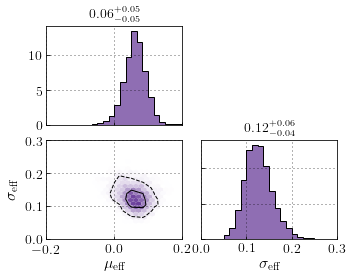

In [24]:
with open('./../Population_Samples/gaussian-spin/gaussian-chiEff-chiP-samples.json','r') as jf:
    data = json.load(jf)

plot_data = {
    'mu_eff':{'data':data['mu_eff'],'plot_bounds':(-0.2,0.2),'priors':(-1.0,1.0),'label':r'$\mu_\mathrm{eff}$'},
    'sigma_eff':{'data':data['sigma_eff'],'plot_bounds':(0.0,0.3),'priors':(0.0,1.0),'label':r'$\sigma_\mathrm{eff}$'}
}

fig = plt.figure(figsize=(5.,4))
plot_corner(fig,plot_data,"#6a3d9a",bins=25,hist_alpha=0.75,kdewidth=0.5)
plt.tight_layout()
fig.subplots_adjust(wspace=0.14, hspace=0.16)
fig.savefig('./Production-Figures/corner_chi_eff.pdf',dpi=200,bbox_inches='tight')
plt.show()

---
## Fig 11b: Chi-Effective PDFs

In [25]:
# Load default spin data
default_data_file = "./Multiple-Fig-Data/effective_spin_ppd/default-spin-xeff-xp-ppd-data.json"
with open(default_data_file,'r') as jf:
    default_data = json.load(jf)
default_chi_eff_grid = np.array(default_data['chi_eff_grid'])
default_chi_eff_data = np.array(default_data['chi_eff_pdfs']).T

# Load Gaussian model data
gaussian_data_file = "./Multiple-Fig-Data/effective_spin_ppd/gaussian-spin-xeff-xp-ppd-data.json"
with open(gaussian_data_file,'r') as jf:
    gaussian_data = json.load(jf)
gaussian_chi_eff_grid = np.array(gaussian_data['chi_eff_grid'])
gaussian_chi_eff_data = np.array(gaussian_data['chi_eff_pdfs'])

In [26]:
from scipy.special import erf
def calculate_Gaussian(x, mu, sigma2, low, high):
    norm = np.sqrt(sigma2*np.pi/2)*(-erf((low-mu)/np.sqrt(2*sigma2)) + erf((high-mu)/np.sqrt(2*sigma2)))
    y = (1.0/norm)*np.exp((-1.0*(x-mu)**2)/(2.*sigma2))
    y[x<low] = 0.   
    return y

0.9652509955154225


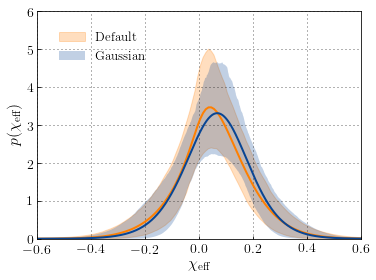

In [27]:
fig,ax = plt.subplots(figsize=(5.33,4))
    
ax.fill_between(default_chi_eff_grid,np.quantile(default_chi_eff_data,0.95,axis=0),
                np.quantile(default_chi_eff_data,0.05,axis=0), color='#ff7f00',alpha=0.25,label='Default')

ax.fill_between(gaussian_chi_eff_grid,np.quantile(gaussian_chi_eff_data,0.95,axis=0),
                np.quantile(gaussian_chi_eff_data,0.05,axis=0),facecolor='#084594',alpha=0.25,label='Gaussian')

print(np.trapz(np.quantile(gaussian_chi_eff_data,0.5,axis=0),gaussian_chi_eff_grid))

ax.plot(default_chi_eff_grid,np.mean(default_chi_eff_data,axis=0),color='#ff7f00',lw=2)
ax.plot(gaussian_chi_eff_grid,np.mean(gaussian_chi_eff_data,axis=0),color='#084594',lw=2)

ax.set_xlim(-0.6,0.6)
ax.set_ylim(0,6)
ax.grid(True,dashes=(1,3))
ax.set_xlabel(r'$\chi_\mathrm{eff}$')
ax.set_ylabel(r'$p(\chi_\mathrm{eff})$')
plt.legend(loc=(0.05,0.75),frameon=False,fontsize=13)

plt.tight_layout()
plt.savefig('./Production-Figures/chi-eff-modelComparison.pdf',bbox_inches='tight',dpi=200)

plt.show()

---
## Fig 12: Postive, Negative, and Vanishing Chi-Effective Fractions
#### Updated July 15, 2020

pPos pNeg 0.23469368419441142
pPos pVan 0.23469368419441142
pNeg pVan 0.2346936841944114


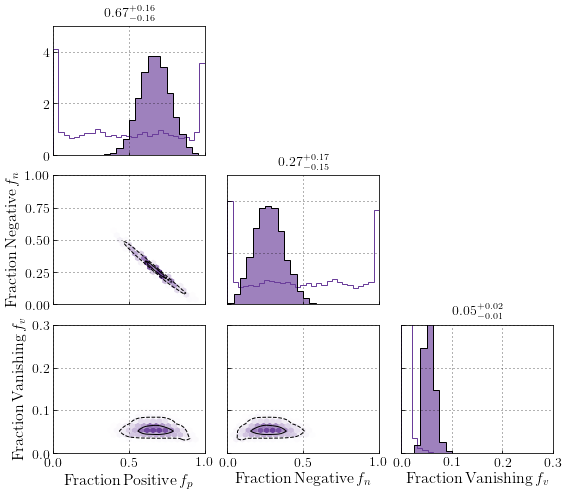

In [28]:
fractionDataFile = "./Fig-12-spin-fractions/chi-effective-fractions.json"
with open(fractionDataFile,'r') as jf:
    fractionData = json.load(jf)

plot_data = {
    'pPos':{'data':fractionData['posterior']['fPos'],'plot_bounds':(0.,1.),'priors':(0.,1.0),'label':r'$\mathrm{Fraction\,Positive}\,f_p$'},
    'pNeg':{'data':fractionData['posterior']['fNeg'],'plot_bounds':(0.,1.),'priors':(0.,1.0),'label':r'$\mathrm{Fraction\,Negative}\,f_n$'},
    'pVan':{'data':fractionData['posterior']['fVan'],'plot_bounds':(0.,0.3),'priors':(0.,1.0),'label':r'$\mathrm{Fraction\,Vanishing}\,f_v$'}
}

pPos_prior = fractionData['prior']['fPos']
pNeg_prior = fractionData['prior']['fNeg']
pVan_prior = fractionData['prior']['fVan']

fig = plt.figure(figsize=(8,7))
plot_corner(fig,plot_data,"#6a3d9a",bins=25,hist_alpha=0.65,mirror=False,kdewidth=1)

ax = fig.axes[0]
ax.hist(pPos_prior,bins=np.linspace(0,1,30),histtype='step',density=True,zorder=-1,color="#6a3d9a")
ax.set_ylim(0,5)

ax = fig.axes[3]
ax.hist(pNeg_prior,bins=np.linspace(0,1,30),histtype='step',density=True,zorder=-1,color="#6a3d9a")
ax.set_ylim(0,5)

ax = fig.axes[5]
ax.hist(pVan_prior,bins=np.linspace(0,0.3,30),histtype='step',density=True,zorder=-1,color="#6a3d9a")
ax.set_ylim(0,30)


plt.tight_layout()
fig.subplots_adjust(wspace=0.15, hspace=0.16)
fig.savefig('./Production-Figures/corner_spin_fraction.pdf',dpi=200,bbox_inches='tight')
plt.show()

pPos pNeg 0.23469368419441142
pPos pVan 0.23469368419441142
pNeg pVan 0.2346936841944114


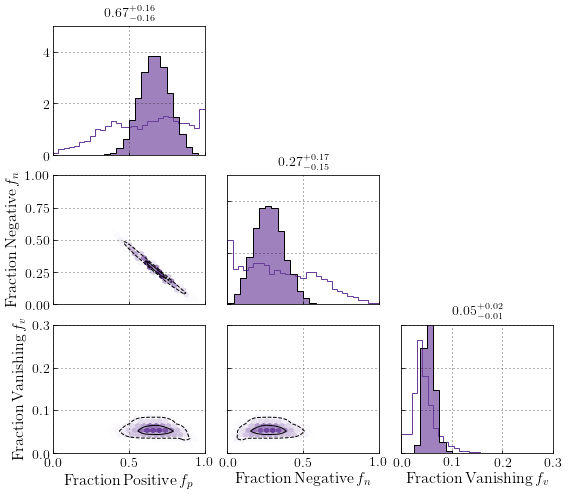

In [29]:
fractionDataFile = "./Fig-12-spin-fractions/chi-effective-fractions.json"
with open(fractionDataFile,'r') as jf:
    fractionData = json.load(jf)

plot_data = {
    'pPos':{'data':fractionData['posterior']['fPos'],'plot_bounds':(0.,1.),'priors':(0.,1.0),'label':r'$\mathrm{Fraction\,Positive}\,f_p$'},
    'pNeg':{'data':fractionData['posterior']['fNeg'],'plot_bounds':(0.,1.),'priors':(0.,1.0),'label':r'$\mathrm{Fraction\,Negative}\,f_n$'},
    'pVan':{'data':fractionData['posterior']['fVan'],'plot_bounds':(0.,0.3),'priors':(0.,1.0),'label':r'$\mathrm{Fraction\,Vanishing}\,f_v$'}
}

pPos_prior = fractionData['restricted_prior']['fPos']
pNeg_prior = fractionData['restricted_prior']['fNeg']
pVan_prior = fractionData['restricted_prior']['fVan']

fig = plt.figure(figsize=(8,7))
plot_corner(fig,plot_data,"#6a3d9a",bins=25,hist_alpha=0.65,mirror=False,kdewidth=1)

ax = fig.axes[0]
ax.hist(pPos_prior,bins=np.linspace(0,1,30),histtype='step',density=True,zorder=-1,color="#6a3d9a")
ax.set_ylim(0,5)

ax = fig.axes[3]
ax.hist(pNeg_prior,bins=np.linspace(0,1,30),histtype='step',density=True,zorder=-1,color="#6a3d9a")
ax.set_ylim(0,5)

ax = fig.axes[5]
ax.hist(pVan_prior,bins=np.linspace(0,0.3,30),histtype='step',density=True,zorder=-1,color="#6a3d9a")
ax.set_ylim(0,30)


plt.tight_layout()
fig.subplots_adjust(wspace=0.15, hspace=0.16)
plt.show()

---
## Fig 13: Multi-spin results

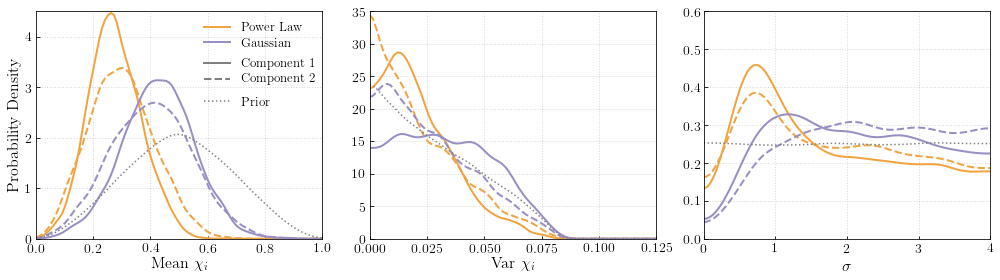

In [12]:
sys.path.append('./Fig-13-multi-spin/')
import plotting_utilities

inputFile = "./Fig-13-multi-spin/post_cleaned.hdf5"

with h5py.File(inputFile) as h5:
    E_chi = plotting_utilities.load_params(h5,'E_chi')
    Var_chi = plotting_utilities.load_params(h5,'Var_chi')
    sigma_cos = plotting_utilities.load_params(h5,'sigma_cos')    
    
color1 = '#f1a340'
color2 = '#998ec3'

# Add in priors
npriors = 100000
E_chi_prior, Var_chi_prior = plotting_utilities.draw_prior_E_Var_chi(npriors)
sigma_cos_prior = plotting_utilities.draw_prior_sigma_cos(npriors)

# Scotts rule for KDE'ing
nSamps = E_chi['1_pl0'].size
scott = nSamps**(-1./5.)
scott_prior = npriors**(-1./5.)

fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(131)

es = np.linspace(0,1,100)
l1, = ax1.plot(es,gaussian_kde(E_chi['1_pl0'],bw_method=scott)(es),color=color1,lw=2,label='Power Law')
l2, = ax1.plot(es,gaussian_kde(E_chi['2_pl0'],bw_method=scott)(es),color=color1,lw=2,ls='--')
ax1.plot(es,gaussian_kde(E_chi['1_g0'],bw_method=scott)(es),color=color2,lw=2,label='Gaussian')
ax1.plot(es,gaussian_kde(E_chi['2_g0'],bw_method=scott)(es),color=color2,lw=2,ls='--')
l3, = ax1.plot(es,gaussian_kde(E_chi_prior,bw_method=scott)(es),color='grey',ls=':')
ax1.xaxis.grid(True,which='major',ls=':',color='grey',alpha=0.3)
ax1.yaxis.grid(True,which='major',ls=':',color='grey',alpha=0.3)
ax1.set_xlim(0,1)
ax1.set_ylim(0,4.5)
ax1.set_xlabel(r'$\mathrm{Mean}\,\,\chi_i$',fontsize=16)
ax1.set_ylabel(r'$\mathrm{Probability\,\,Density}$',fontsize=16)

# Define what will become the second legend (explaining the linestyles of line1 and line2)
legend2 = plt.legend([l1,l2],['Component 1','Component 2'],fontsize=13,frameon=False,loc=(0.57,0.65),labelspacing=0.17)
legend2.legendHandles[0].set_color('grey')
legend2.legendHandles[1].set_color('grey')

# Define what will become the second legend (explaining the linestyles of line1 and line2)
legend3 = plt.legend([l3],['Prior'],fontsize=13,frameon=False,loc=(0.57,0.55))

# Save legend
ax1.add_artist(legend2)
ax1.add_artist(legend3)
ax1.legend(loc=(0.57,0.81),fontsize=13,frameon=False,labelspacing=0.17)

ax2 = fig.add_subplot(132)

# Deal with a lower boundary by reflecting samples about var = 0
# Note that, since we're inflating the std dev by a factor of 2,
# we'll divide our bin width (specified in units of std dev) by 2 below
var_1_pl = np.append(Var_chi['1_pl0'],-Var_chi['1_pl0'])
var_2_pl = np.append(Var_chi['2_pl0'],-Var_chi['2_pl0'])
var_1_g = np.append(Var_chi['1_g0'],-Var_chi['1_g0'])
var_2_g = np.append(Var_chi['2_g0'],-Var_chi['2_g0'])
var_priors = np.append(Var_chi_prior,-Var_chi_prior)

vs = np.linspace(0,0.15,100)
ls1, = ax2.plot(vs,gaussian_kde(var_1_pl,bw_method=scott/2)(vs)/np.trapz(gaussian_kde(var_1_pl,bw_method=scott/2)(vs),vs),color=color1,lw=2,label='Power Law')
ls2, = ax2.plot(vs,gaussian_kde(var_2_pl,bw_method=scott/2)(vs)/np.trapz(gaussian_kde(var_2_pl,bw_method=scott/2)(vs),vs),color=color1,lw=2,ls='--')
ax2.plot(vs,gaussian_kde(var_1_g,bw_method=scott/2)(vs)/np.trapz(gaussian_kde(var_1_g,bw_method=scott/2)(vs),vs),color=color2,lw=2,label='Gaussian')
ax2.plot(vs,gaussian_kde(var_2_g,bw_method=scott/2)(vs)/np.trapz(gaussian_kde(var_2_g,bw_method=scott/2)(vs),vs),color=color2,lw=2,ls='--')
ls3, = ax2.plot(vs,gaussian_kde(var_priors,bw_method=scott/2)(vs)/np.trapz(gaussian_kde(var_priors,bw_method=scott/2)(vs),vs),color='grey',ls=':')
ax2.xaxis.grid(True,which='major',ls=':',color='grey',alpha=0.3)
ax2.yaxis.grid(True,which='major',ls=':',color='grey',alpha=0.3)
ax2.set_xlim(0,0.125)
ax2.set_ylim(0,35)
ax2.set_xlabel(r'$\mathrm{Var}\,\,\chi_i$',fontsize=16)

ax3 = fig.add_subplot(133)

# Deal with hard upper and lower boundaries by reflecting samples about sig=0 and sig=4
# Here, we're inflating the std dev by 3, so we'll have to modify our bandwidth accordingly
sig_1_pl = np.concatenate([sigma_cos['1_pl0'],-sigma_cos['1_pl0'],2.*4-sigma_cos['1_pl0']])
sig_2_pl = np.concatenate([sigma_cos['2_pl0'],-sigma_cos['2_pl0'],2.*4-sigma_cos['2_pl0']])
sig_1_g = np.concatenate([sigma_cos['1_g0'],-sigma_cos['1_g0'],2.*4-sigma_cos['1_g0']])
sig_2_g = np.concatenate([sigma_cos['2_g0'],-sigma_cos['2_g0'],2.*4-sigma_cos['2_g0']])
sig_priors = np.concatenate([sigma_cos_prior,-sigma_cos_prior,2.*4-sigma_cos_prior])

sigs = np.linspace(0,4,100)
ax3.plot(sigs,gaussian_kde(sig_1_pl,bw_method=scott/3)(sigs)/np.trapz(gaussian_kde(sig_1_pl,bw_method=scott/3)(sigs),sigs),color=color1,lw=2)
ax3.plot(sigs,gaussian_kde(sig_2_pl,bw_method=scott/3)(sigs)/np.trapz(gaussian_kde(sig_2_pl,bw_method=scott/3)(sigs),sigs),color=color1,lw=2,ls='--')
ax3.plot(sigs,gaussian_kde(sig_1_g,bw_method=scott/3)(sigs)/np.trapz(gaussian_kde(sig_1_g,bw_method=scott/3)(sigs),sigs),color=color2,lw=2)
ax3.plot(sigs,gaussian_kde(sig_2_g,bw_method=scott/3)(sigs)/np.trapz(gaussian_kde(sig_2_g,bw_method=scott/3)(sigs),sigs),color=color2,lw=2,ls='--')
ax3.plot(sigs,gaussian_kde(sig_priors,bw_method=scott/3)(sigs)/np.trapz(gaussian_kde(sig_priors,bw_method=scott/3)(sigs),sigs),color='grey',ls=':')
ax3.xaxis.grid(True,which='major',ls=':',color='grey',alpha=0.3)
ax3.yaxis.grid(True,which='major',ls=':',color='grey',alpha=0.3)
ax3.set_xlim(0,4)
ax3.set_ylim(0,0.6)
ax3.set_xlabel(r'$\sigma$',fontsize=16)

plt.tight_layout()
plt.savefig('./Production-Figures/multi-spin.pdf',bbox_inches='tight')

plt.show()

---
## Fig X: BBH merger rate
#### Updated July 15, 2020

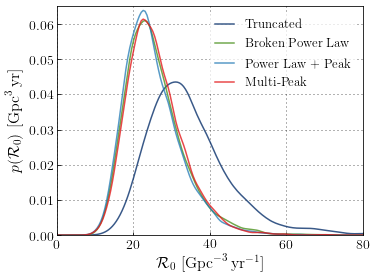

In [31]:
# Open files with rates posteriors for all four mass models
# This data assumes no evolution of the merger rate with redshift
#with open("/home/shanika.galaudage/projects/gwinference/condor/o3a/population_runs_200415/fixed_redshift_evolution/outdir_o1o2o3_190814/result/o1o2o3_190814_mass_b_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json","r") as jfile:
with open("../Population_Samples/default/o1o2o3_mass_b_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json","r") as jfile:
    jf = json.load(jfile)
    posterior_samples_truncated = jf['posterior']['content']

with open("../Population_Samples/default/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json","r") as jfile:
    jf = json.load(jfile)
    posterior_samples_plpeak = jf['posterior']['content']
    
with open("../Population_Samples/default/o1o2o3_mass_d_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json","r") as jfile:
    jf = json.load(jfile)
    posterior_samples_bpl = jf['posterior']['content']
    
with open("../Population_Samples/default/o1o2o3_mass_e_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json","r") as jfile:
    jf = json.load(jfile)
    posterior_samples_multi = jf['posterior']['content']

# Build a KDE of each of the four rate posteriors
kde_truncated = gaussian_kde(posterior_samples_truncated['rate'])
kde_plpeak = gaussian_kde(posterior_samples_plpeak['rate'])
kde_bpl = gaussian_kde(posterior_samples_bpl['rate'])
kde_multi = gaussian_kde(posterior_samples_multi['rate'])
    
fig,ax = plt.subplots(figsize=(5.33,4.))
ax.set_xlim(0.,80.)
ax.set_ylim(0.,0.065)

# Set up a grid of rate densities and plot KDE
rates = np.linspace(0.,100.,200)
ax.plot(rates,kde_truncated(rates),color=color_truncated,lw=1.5,alpha=0.8,label='Truncated')
ax.plot(rates,kde_bpl(rates),color=color_broken,lw=1.5,alpha=0.8,label='Broken Power Law')
ax.plot(rates,kde_plpeak(rates),color=color_plpeak,lw=1.5,alpha=0.75,label='Power Law + Peak')
ax.plot(rates,kde_multi(rates),color=color_multipeak,lw=1.5,alpha=0.8,label='Multi-Peak')

# Create legend
leg = plt.legend(loc='upper right',fontsize=13,handlelength=1.5,framealpha=0.75)
leg.get_frame().set_linewidth(0.0)

# Misc formatting
ax.grid(True,dashes=(1,3))
ax.set_xlabel(r'$\mathcal{R}_0$ $[\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}]$')
ax.set_ylabel(r'$p(\mathcal{R}_0)$ $[\mathrm{Gpc}^{3}\,\mathrm{yr}]$')

plt.tight_layout()
plt.savefig('./Production-Figures/localRates.pdf',bbox_inches='tight')
plt.show()

---
## Fig 14: BBH redshift evolution parameter
#### Updated July 15, 2020

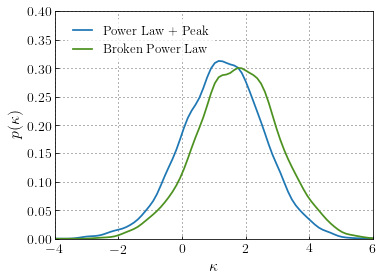

In [32]:
# Load posteriors for runs with evolving merger rates
with open("../Population_Samples/evolving_redshift/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json","r") as jfile:
    jf = json.load(jfile)
    posterior_samples_plpeak = jf['posterior']['content']

with open("../Population_Samples/evolving_redshift/o1o2o3_mass_d_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json","r") as jfile:
    jf = json.load(jfile)
    posterior_samples_bpl = jf['posterior']['content']

# Build a KDE for each set of posterior samples   
# NOTE: Although this variable is called "kappa" in the text (see Appendix 7.8),
# in these datafiles it is called "lamb". This is **not** the same as the parameter 'lam'
# appearing in the Power Law + Peak mass model
kde_plpeak = gaussian_kde(posterior_samples_plpeak['lamb'])
kde_bpl = gaussian_kde(posterior_samples_bpl['lamb'])
    
fig,ax = plt.subplots(figsize=(5.33,4))

# Plot bounds
x_min = -4.
x_max = 6.
y_min = 0.
y_max = 0.4

# Build array of kappas and plot
kappas = np.linspace(-6,6,100)
ax.plot(kappas,kde_plpeak(kappas),label='Power Law + Peak',color=color_plpeak,lw=1.75)
ax.plot(kappas,kde_bpl(kappas),label='Broken Power Law',color=color_broken,lw=1.75)

# Legend
leg = plt.legend(loc=(0.04,0.78),fontsize=13,handlelength=1.5,framealpha=0.75)
leg.get_frame().set_linewidth(0.0)

# Misc formatting
ax.grid(True,dashes=(1,3))
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)
ax.set_xlabel(r'$\kappa$')
ax.set_ylabel(r'$p(\kappa)$')

plt.tight_layout()
plt.savefig('./Production-Figures/kappa.pdf',bbox_inches='tight')
plt.show()

---
## Fig 15: BBH merger rate vs. redshift
#### Updated July 15, 2020

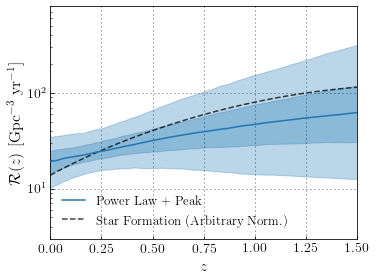

In [33]:
# Helper function to make posterior plot of merger rate as a function of redshift
def make_Rz_plot(data, ax, ps = [5, 25,50,75, 95], color = color_plpeak, label = None, ppd = False, nsamps = 1000):
    
    # Select random subset of posterior samples
    random_inds = np.random.choice(len(data['lamb']), nsamps, replace = False)
    
    # Read off kappas and local rates
    # In the input datafiles, the "kappa" parameter is called "lamb"
    ks = np.array(data['lamb'])[random_inds]
    rs = np.array(data['rate'])[random_inds]
    
    # Build array of redshift distributions
    xs = np.linspace(0.0, 2.0, 1000)
    ys = np.zeros((len(xs), len(ks)))
    for i in range(len(ks)):
        ys[:,i] = rs[i]*(1+xs)**ks[i]
        
    ax.plot(xs, np.percentile(ys, ps[2], axis = -1), color = color, label = label,zorder=10)
    ax.fill_between(xs, np.percentile(ys, ps[1], axis = -1), np.percentile(ys, ps[3], axis = -1),alpha=0.3, color = color,zorder=0)
    ax.fill_between(xs, np.percentile(ys, ps[0], axis = -1), np.percentile(ys, ps[4], axis = -1), alpha=0.3, color = color,zorder=0)
    if ppd:
        ax.plot(xs, np.mean(ys, axis = -1), color = color, ls = '--',zorder=10)
        
with open("../Population_Samples/evolving_redshift/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json","r") as jfile:
    jf = json.load(jfile)
    posterior_samples_plpeak = jf['posterior']['content']
        
fig = plt.figure(figsize=(5.33,4.))
ax = fig.add_subplot(111)
ax.set_rasterization_zorder(1)

make_Rz_plot(posterior_samples_plpeak,ax,label ='Power Law + Peak', color = color_plpeak)

zs = np.linspace(0.,2.,100)
rate_md = np.power(1.+zs,2.7)/(1.+np.power((1.+zs)/2.9,5.6))
rate_md = rate_md*np.median(posterior_samples_plpeak['rate'])/rate_md[0]
ax.plot(zs,rate_md/1.38,color='black',alpha=0.75,label='Star Formation (Arbitrary Norm.)',ls='--')

ax.grid(True,dashes=(1,3))
ax.set_yscale('log')
ax.set_xlim(0,1.5)
ax.set_ylim(3,800)
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\mathcal{R}(z)$ [Gpc$^{-3}$ yr$^{-1}$]')

leg = plt.legend(loc='lower left',fontsize=13,framealpha=0.75,frameon=False,handlelength=1.8)
leg.get_frame().set_linewidth(0.0)

plt.tight_layout()
plt.savefig('./Production-Figures/rateEvolution.pdf',bbox_inches='tight',dpi=200)
plt.show()

---
## Fig 16: Power Law + Peak Corner Plot
#### Updated July 15, 2020

alpha beta 0.011623917325759067
alpha delta_m 0.020640079751659865
alpha mmin 0.014667119096326517
alpha mmax 0.013423564862843301
alpha lam 0.010292066165917168
alpha mpp 0.013397010593828232
alpha sigpp 0.02124017952298881
beta delta_m 0.03527897283536196
beta mmin 0.0250697139932664
beta mmax 0.022944173949322254
beta lam 0.0175916724671541
beta mpp 0.02289878617240874
beta sigpp 0.03630469094236289
delta_m mmin 0.04451519067721275
delta_m mmax 0.040740962523926325
delta_m lam 0.031236760595544654
delta_m mpp 0.04066036944080369
delta_m sigpp 0.06446464607496685
mmin mmax 0.028951077545586894
mmin lam 0.022197263448143805
mmin mpp 0.028893807013557836
mmin sigpp 0.04580944709809268
mmax lam 0.020315264621285238
mmax mpp 0.026444040580410375
mmax sigpp 0.04192548518994767
lam mpp 0.020275077308348776
lam sigpp 0.03214495344731577
mpp sigpp 0.04184254890411775


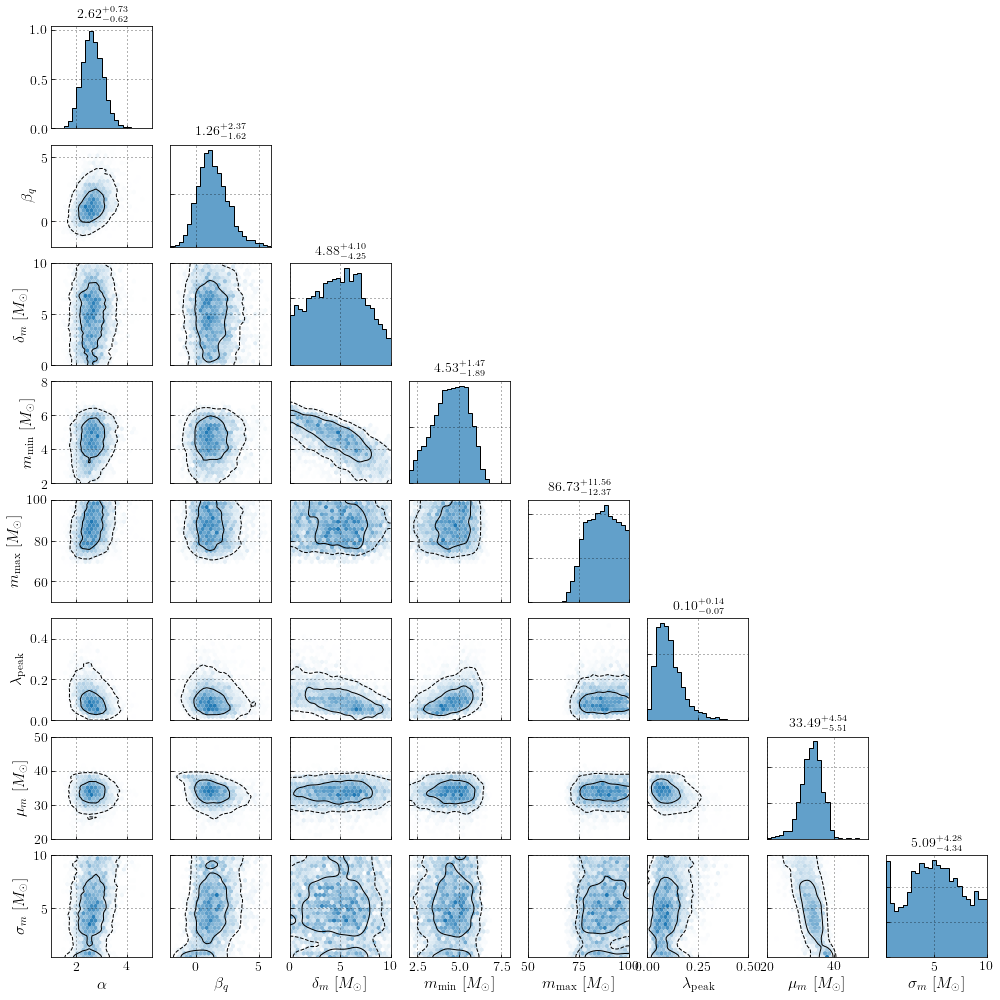

In [57]:
with open("../Population_Samples/default/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json","r") as jfile:
    jf = json.load(jfile)
    
parameter_labels = jf['parameter_labels']
posterior_samples = jf['posterior']['content']

parameters_to_plot = ['alpha', 'beta', 'delta_m', 'mmin', 'mmax', 'lam', 'mpp', 'sigpp']

test_data = {
    'alpha':{'data':posterior_samples['alpha'],'plot_bounds':(1.,5.),'priors':(-4.,12.),'label':r'$\alpha$'},
    'beta':{'data':posterior_samples['beta'],'plot_bounds':(-2.,6.),'priors':(-4.,12.),'label':r'$\beta_q$'},
    'delta_m':{'data':posterior_samples['delta_m'],'plot_bounds':(0.,10.),'priors':(0.,10.),'label':r'$\delta_m$ $[M_\odot]$'},
    'mmin':{'data':posterior_samples['mmin'],'plot_bounds':(2.,8.),'priors':(2.,10.),'label':r'$m_\mathrm{min}$ $[M_\odot]$'},
    'mmax':{'data':posterior_samples['mmax'],'plot_bounds':(50.,100.),'priors':(30.,100.),'label':r'$m_\mathrm{max}$ $[M_\odot]$'},
    'lam':{'data':posterior_samples['lam'],'plot_bounds':(0.,0.5),'priors':(0.,1.),'label':r'$\lambda_\mathrm{peak}$'},
    'mpp':{'data':posterior_samples['mpp'],'plot_bounds':(20,50),'priors':(20.,50.),'label':r'$\mu_m$ $[M_\odot]$'},
    'sigpp':{'data':posterior_samples['sigpp'],'plot_bounds':(0.4,10),'priors':(0.4,10),'label':r'$\sigma_m$ $[M_\odot]$'}
}

fig = plt.figure(figsize=(14,14))
plot_corner(fig,test_data,color_plpeak,bins=25)
plt.tight_layout()
fig.subplots_adjust(wspace=0.18, hspace=0.16)
fig.savefig('Production-Figures/corner_plpeak.pdf',dpi=100)
plt.show()

---
## Fig 17: Broken Power Law Corner
#### Updated July 15, 2020

alpha_1 alpha_2 0.017324513956925195
alpha_1 beta 0.013640234145437137
alpha_1 delta_m 0.0250177897347331
alpha_1 mmin 0.018149448606480705
alpha_1 mmax 0.015550528686101647
alpha_1 break_fraction 0.017461822378981945
alpha_2 beta 0.025755263322428217
alpha_2 delta_m 0.04723817461584659
alpha_2 mmin 0.03426948709477655
alpha_2 mmax 0.029362249712370038
alpha_2 break_fraction 0.03297112268491319
beta delta_m 0.03719237168588087
beta mmin 0.026981641688708695
beta mmax 0.023117991194980973
beta break_fraction 0.025959391102015655
delta_m mmin 0.04948749642188713
delta_m mmax 0.04240110812166047
delta_m break_fraction 0.04761256891247564
mmin mmax 0.030760380548066766
mmin break_fraction 0.03454109582269685
mmax break_fraction 0.029594965284423954


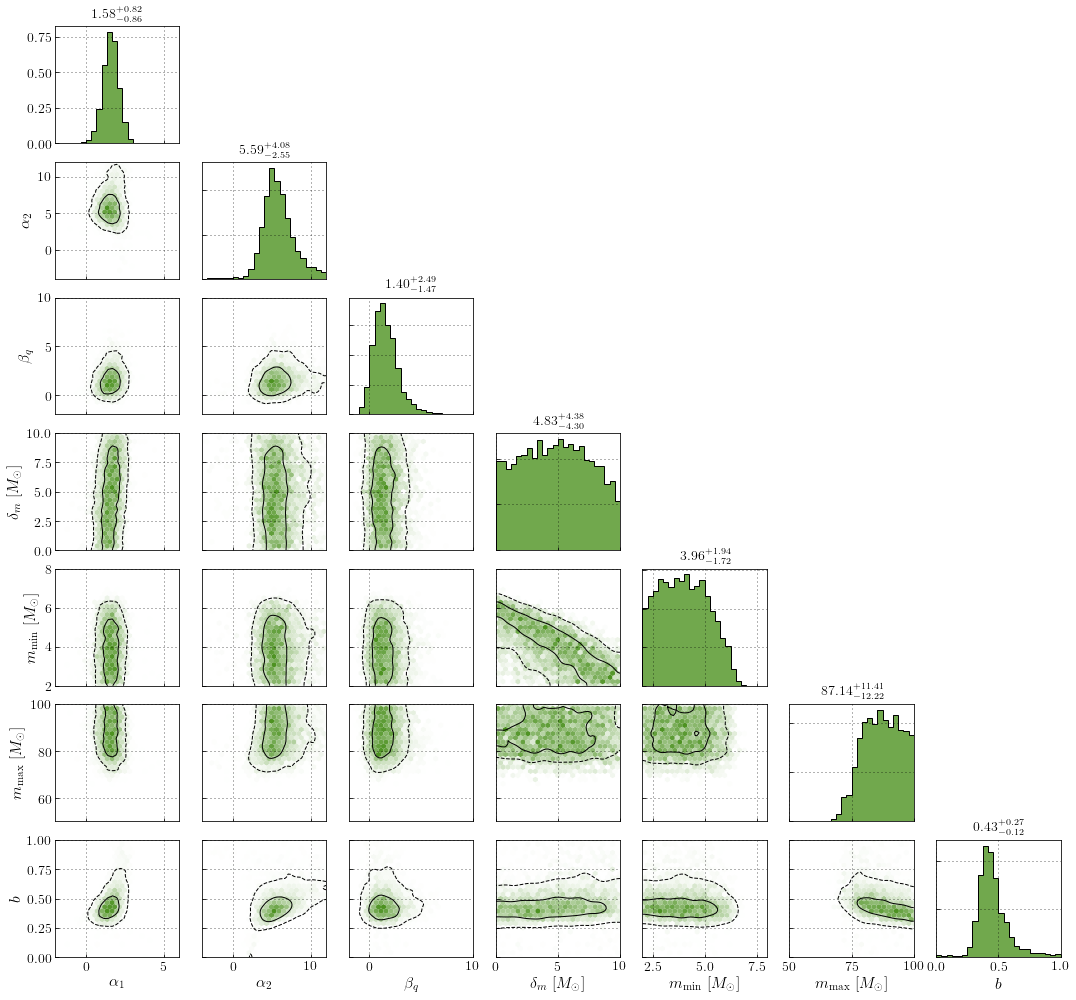

In [35]:
with open("../Population_Samples/default/o1o2o3_mass_d_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json","r") as jfile:
    jf = json.load(jfile)
    
parameter_labels = jf['parameter_labels']
posterior_samples = jf['posterior']['content']

test_data = {
    'alpha_1':{'data':posterior_samples['alpha_1'],'plot_bounds':(-2.,6.),'priors':(-4.,12.),'label':r'$\alpha_1$',},
    'alpha_2':{'data':posterior_samples['alpha_2'],'plot_bounds':(-4.,12.),'priors':(-4.,12.),'label':r'$\alpha_2$',},
    'beta':{'data':posterior_samples['beta'],'plot_bounds':(-2.,10.),'priors':(-4.,12.),'label':r'$\beta_q$'},
    'delta_m':{'data':posterior_samples['delta_m'],'plot_bounds':(0.,10.),'priors':(0.,10.),'label':r'$\delta_m$ $[M_\odot]$'},
    'mmin':{'data':posterior_samples['mmin'],'plot_bounds':(2.,8.),'priors':(2.,10.),'label':r'$m_\mathrm{min}$ $[M_\odot]$'},
    'mmax':{'data':posterior_samples['mmax'],'plot_bounds':(50.,100.),'priors':(30.,100.),'label':r'$m_\mathrm{max}$ $[M_\odot]$'},
    'break_fraction':{'data':posterior_samples['break_fraction'],'plot_bounds':(0.,1),'priors':(0.,1.),'label':r'$b$'}
}

fig = plt.figure(figsize=(15,14))
plot_corner(fig,test_data,color_broken,bins=25,hist_alpha=0.8)
plt.tight_layout()
fig.subplots_adjust(wspace=0.18, hspace=0.16)
fig.savefig('./Production-Figures/corner_broken.pdf',dpi=100)
plt.show()

---
## Fig 18: Mass PPCs

/opt/ligo-py/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:37: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/opt/ligo-py/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:37: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/opt/ligo-py/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:37: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/opt/ligo-py/envs/ligo-py37/lib/python3.7/site-packages/ipykernel/__main__.py:37: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


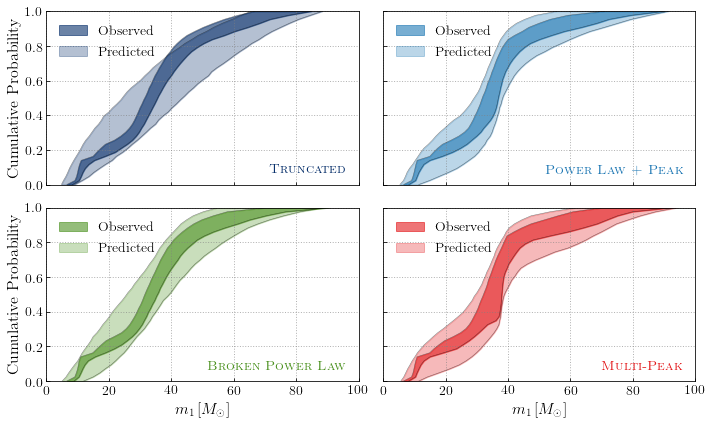

In [58]:
files = ["Multiple-Fig-Data/synthetic_observed_samples/o1o2o3_mass_b_iid_mag_two_comp_iid_tilt_powerlaw_redshift_full_posterior.hdf5",
         "Multiple-Fig-Data/synthetic_observed_samples/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_full_posterior.hdf5",
         "Multiple-Fig-Data/synthetic_observed_samples/o1o2o3_mass_d_iid_mag_two_comp_iid_tilt_powerlaw_redshift_full_posterior.hdf5",
         "Multiple-Fig-Data/synthetic_observed_samples/o1o2o3_mass_e_iid_mag_two_comp_iid_tilt_powerlaw_redshift_full_posterior.hdf5"]

colors = ["#08306b",
        "#1f78b4",
        "#4d9221",
        "#e31a1c"]

labels = [r"\textsc{Truncated}",
          r"\textsc{Power Law + Peak}",
          r"\textsc{Broken Power Law}",          
          r"\textsc{Multi-Peak}"]

fig = plt.figure(figsize=(10,6))

# Loop across models
for i,f in enumerate(files):
    
    # Load in predicted and observed data
    h5data = h5py.File(f,'r')
    data = h5data["samples"][:]
    events = [event.decode() for event in h5data["events"]]
    data_frame = pd.DataFrame()
    for name in data.dtype.names:
        data_frame[name] = data[name]
    
    synthetic = np.array([
            data[f"synthetic_mass_1_{ii}"] for ii in range(len(events))
            ])

    observed = np.array([
            data[f"{name}_mass_1"] for name in events
            ])
    
    ax = fig.add_subplot('22{0}'.format(i+1))
    ax.xaxis.grid(True,which='major',ls=':',color='grey')
    ax.yaxis.grid(True,which='major',ls=':',color='grey')
    
    if i==0 or i==1:
        ax.set_xticklabels([])
        
    if i==1 or i==3:
        ax.set_yticklabels([])
        
    if i==2 or i==3:
        ax.set_xlabel("$m_1\,[M_\odot]$",fontsize=16)
        
    if i==0 or i==2:
        ax.set_ylabel("Cumulative Probability",fontsize=16)
    
    # Fill horizontally across the m1 range typically occupied by the i-th catalog event
    ax.fill_betweenx(y = np.linspace(0,1,len(observed[:,0])),
                    x1 = np.quantile(np.sort(observed,axis=0),0.05,axis=1),
                    x2 = np.quantile(np.sort(observed,axis=0),0.95,axis=1),
                    color = colors[i], alpha=0.6, label='Observed'
                    )
    ax.plot(np.quantile(np.sort(observed,axis=0),0.05,axis=1),np.linspace(0,1,len(observed[:,0])),
           color='black',lw=0.5,alpha=0.5)
    ax.plot(np.quantile(np.sort(observed,axis=0),0.95,axis=1),np.linspace(0,1,len(observed[:,0])),
           color='black',lw=0.5,alpha=0.5)
    
    ax.fill_betweenx(y = np.linspace(0,1,len(synthetic[:,0])),
                    x1 = np.quantile(np.sort(synthetic,axis=0),0.05,axis=1),
                    x2 = np.quantile(np.sort(synthetic,axis=0),0.95,axis=1),
                    color = colors[i], alpha=0.3, label='Predicted'
                    )
    ax.plot(np.quantile(np.sort(synthetic,axis=0),0.05,axis=1),np.linspace(0,1,len(synthetic[:,0])),
           color='black',lw=0.5,alpha=0.5)
    ax.plot(np.quantile(np.sort(synthetic,axis=0),0.95,axis=1),np.linspace(0,1,len(synthetic[:,0])),
           color='black',lw=0.5,alpha=0.5)
    
    ax.legend(loc='upper left',frameon=False,fontsize=14)
    plt.text(0.96,0.12,labels[i],fontsize=14,transform=ax.transAxes,color=colors[i],ha='right', va='top')
    
    ax.set_xlim(0,100)
    ax.set_ylim(0,1)

plt.tight_layout()
plt.savefig('./Production-Figures/mass-ppcheck.pdf',bbox_inches='tight')
plt.show()

---
## Fig 19: Mass PPDs with/without 190521
#### Updated July 15, 2020

Plotting data from <HDF5 file "o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_mass_data.h5" (mode r)>
Plotting data from <HDF5 file "o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_mass_data.h5" (mode r)>


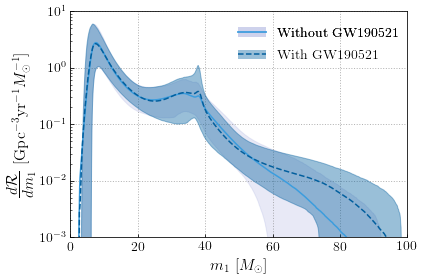

In [57]:
colours = ["#3487bf","#025f9e"]

file_w190521 = "./Multiple-Fig-Data/mass_ppd/default/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_mass_data.h5"
file_wout190521 = "./Multiple-Fig-Data/mass_ppd/no_190521/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_mass_data.h5"

limits = [5,95]
mass_1 = np.linspace(2, 100, 1000)
mass_ratio = np.linspace(0.1, 1, 500)

fig,ax = plt.subplots(figsize=(6,4))
    
with h5py.File(file_wout190521,"r") as f:

    # Load mass distribution data
    ppd = f["ppd"]
    lines = f["lines"]

    mass_1_ppd = np.trapz(ppd, mass_ratio, axis=0)
    mass_ratio_ppd = np.trapz(ppd, mass_1, axis=-1)

    print("Plotting data from {}".format(f))
    p1_wout190521, = ax.plot(mass_1, mass_1_ppd, color="#3c9dde", linestyle='solid',zorder=3)
    ax.fill_between(
        mass_1,
        np.percentile(lines["mass_1"], limits[0], axis=0),
        np.percentile(lines["mass_1"], limits[1], axis=0),
        color="#b3b9e3",
        alpha=0.3,
        zorder=1
    )
    
with h5py.File(file_w190521,"r") as f:

    # Load mass distribution data
    ppd = f["ppd"]
    lines = f["lines"]

    mass_1_ppd = np.trapz(ppd, mass_ratio, axis=0)
    mass_ratio_ppd = np.trapz(ppd, mass_1, axis=-1)

    print("Plotting data from {}".format(f))
    p1_w190521, = ax.plot(mass_1, mass_1_ppd, color=colours[1], linestyle='dashed',zorder=4)
    ax.fill_between(
        mass_1,
        np.percentile(lines["mass_1"], limits[0], axis=0),
        np.percentile(lines["mass_1"], limits[1], axis=0),
        color=colours[1],
        alpha=0.4,
        zorder=2
    )

ax.set_xlim(0, 100)
ax.set_yscale('log')
ax.set_ylim(1e-3,1e1)

ax.xaxis.grid(True,which='major',ls=':',color='grey')
ax.yaxis.grid(True,which='major',ls=':',color='grey')

ax.set_xlabel("$m_{1}$ [$M_{\\odot}$]")

p2_wout190521 = Rectangle((0,0),1,1,color='#b3b9e3', alpha=0.4, fill=True,linewidth=0)
p2_w190521 = Rectangle((0,0),1,1,color=colours[1], alpha=0.4, fill=True,linewidth=0)
leg1 = plt.legend(((p2_w190521,p1_w190521),),('With GW190521',),frameon=False,loc=(0.48,0.75),fontsize=14)
leg2 = plt.legend(((p2_wout190521,p1_wout190521),),('Without GW190521',),frameon=False,loc=(0.48,0.85),fontsize=14)

ax.add_artist(leg1)
ax.add_artist(leg2)

ylabel = r"{\fontsize{22pt}{3em}$\frac{d\mathcal{R}}{dm_{1}}$} [Gpc$^{-3}$yr$^{-1}M_{\odot}^{-1}$]"
ax.set_ylabel(ylabel)
plt.tight_layout()
plt.savefig('Production-Figures/primary_mass_190521_comparison.pdf',bbox_inches='tight')

---
## Fig 20: Reweighted 190521 posteriors

/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/deepdish/io/hdf5io.py:655: UserWarning: This file was saved with a newer version of deepdish. Please upgrade to make sure it loads correctly.
  warnings.warn('This file was saved with a newer version of '


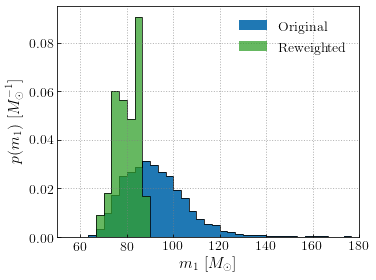

In [113]:
# Load data
data  = dd.io.load("../Event_Samples/default/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_samples.hdf5")
events = data['names']
idx = events.index("S190521g")
mass_1  = data['original']['mass_1'][idx]
weights = data['original']['weights'][idx]


# Plot data
fig,ax = plt.subplots(figsize=(5.33,4.))

ax.hist(mass_1, histtype="stepfilled", density=True, bins=np.linspace(50,180,40), label='Original',\
       color='#1f78b4')
ax.hist(mass_1, histtype="step", density=True, bins=np.linspace(50,180,40),\
       color='black',lw=0.8)

ax.hist(mass_1, histtype="stepfilled", density=True, bins=np.linspace(50,180,40), label='Reweighted', weights=weights,\
       color='#33a02c',alpha=0.75)
ax.hist(mass_1, histtype="step", density=True, bins=np.linspace(50,180,40), weights=weights,\
       color='black',lw=0.75)

ax.set_xlabel(r'$m_1$ $[M_\odot]$')
ax.set_ylabel(r'$p(m_1)$ $[M_\odot^{-1}]$')
ax.xaxis.grid(True,which='major',ls=':',color='grey')
ax.yaxis.grid(True,which='major',ls=':',color='grey')
ax.set_xlim(50,180)
plt.legend(loc='upper right',frameon=False,fontsize=14)

plt.tight_layout()
plt.savefig("Production-Figures/population_weighted_GW190521_m1_dist.pdf",bbox_inches='tight')


---
## Fig 21a: m1 vs. m2, with and without 190814

In [59]:
def read_samples(filename):
    with h5py.File(filename, "r") as ff:
        data = ff["samples"][:]
        events = [event.decode() for event in ff["events"]]
    data_frame = pd.DataFrame()
    for name in data.dtype.names:
        data_frame[name] = data[name]
    return data_frame, events

astro_ppd_samples = "Fig-21-GW190814-outlier-analysis/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_ppd_45_event_samples_excludes_190814.json"
astro_ppd_samples_all_events = "Fig-21-GW190814-outlier-analysis/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_ppd_45_event_samples_all_events.json"
observed_ppd_samples = "Fig-21-GW190814-outlier-analysis/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_full_posterior_draw_45_events_excludes_190814.hdf5"
observed_ppd_samples_all_events = "Fig-21-GW190814-outlier-analysis/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_full_posterior_draw_45_events_all_events.hdf5"

observed_samples = [observed_ppd_samples, observed_ppd_samples_all_events]

# Read in observed data
synthetic_data = []
for fname in observed_samples:
    
    data, events = read_samples(fname)
    
    # ignoring number of events using fixed number instead
    n_events = 45
    parameters = [
        "_".join(key.split("_")[1:]) for key in data
        if events[0] in key and "prior" not in key
        ]
    
    synthetic = {
        key: np.array([
            data[f"synthetic_{key}_{ii}"] for ii in range(n_events)
            if f"synthetic_{key}_{ii}" in data
        ])
        for key in parameters
        if any([f"synthetic_{key}_{ii}" in data for ii in range(n_events)])
    }
    synthetic_data.append(synthetic)

synthetic_no190814 = synthetic_data[0]
synthetic_w190814 = synthetic_data[1]

#Read in astrophysical data
data_no190814 = pd.read_json(astro_ppd_samples)
data_w190814 = pd.read_json(astro_ppd_samples_all_events)

# Plot m1 m2 ppd data
data_no190814["mass_2"]= data_no190814["mass_1"]*data_no190814["mass_ratio"]
data_w190814["mass_2"]= data_w190814["mass_1"]*data_w190814["mass_ratio"]

synthetic_no190814["mass_2"]= synthetic_no190814["mass_1"]*synthetic_no190814["mass_ratio"]
synthetic_w190814["mass_2"]= synthetic_w190814["mass_1"]*synthetic_w190814["mass_ratio"]

In [60]:
m1_astro_no190814 = np.concatenate([data_no190814["mass_1"].values, data_no190814["mass_2"].values, data_no190814["mass_1"].values])
m2_astro_no190814 = np.concatenate([data_no190814["mass_2"].values, data_no190814["mass_1"].values, -data_no190814["mass_2"].values])

# The next chunk of code creates contours
# First construct a KDE and evaluate it on a grid across m1 vs m2 space
kde_no190814 = gaussian_kde([m1_astro_no190814,m2_astro_no190814])
x_gridpoints = np.linspace(0,100,60)
y_gridpoints = np.linspace(0,100,59)
x_grid,y_grid = np.meshgrid(x_gridpoints,y_gridpoints)
z_grid_no190814 = kde_no190814([x_grid.reshape(-1),y_grid.reshape(-1)]).reshape(y_gridpoints.size,x_gridpoints.size)

# Sort the resulting z-values to get estimates of where to place 99% contour
sortedVals = np.sort(z_grid_no190814.flatten())[::-1]
cdfVals = np.cumsum(sortedVals)/np.sum(sortedVals)
i99 = np.argmin(np.abs(cdfVals - 0.99))
val99_no190814 = sortedVals[i99]

In [61]:
m1_astro_w190814 = np.concatenate([data_w190814["mass_1"].values, data_w190814["mass_2"].values, data_w190814["mass_1"].values])
m2_astro_w190814 = np.concatenate([data_w190814["mass_2"].values, data_w190814["mass_1"].values, -data_w190814["mass_2"].values])

# The next chunk of code creates contours
# First construct a KDE and evaluate it on a grid across m1 vs m2 space
kde_w190814 = gaussian_kde([m1_astro_w190814,m2_astro_w190814])
z_grid_w190814 = kde_w190814([x_grid.reshape(-1),y_grid.reshape(-1)]).reshape(y_gridpoints.size,x_gridpoints.size)

# Sort the resulting z-values to get estimates of where to place 99% contour
sortedVals = np.sort(z_grid_w190814.flatten())[::-1]
cdfVals = np.cumsum(sortedVals)/np.sum(sortedVals)
i99 = np.argmin(np.abs(cdfVals - 0.99))
val99_w190814 = sortedVals[i99]

In [62]:
m1_obs_w190814 = np.concatenate([synthetic_w190814["mass_1"], synthetic_w190814["mass_2"], synthetic_w190814["mass_1"]]).reshape(-1)
m2_obs_w190814 = np.concatenate([synthetic_w190814["mass_2"], synthetic_w190814["mass_1"], -synthetic_w190814["mass_2"]]).reshape(-1)

# The next chunk of code creates contours
# First construct a KDE and evaluate it on a grid across m1 vs m2 space
kde_w190814_obs = gaussian_kde([m1_obs_w190814,m2_obs_w190814])
z_grid_w190814_obs = kde_w190814_obs([x_grid.reshape(-1),y_grid.reshape(-1)]).reshape(y_gridpoints.size,x_gridpoints.size)

# Sort the resulting z-values to get estimates of where to place 99% contour
sortedVals = np.sort(z_grid_w190814_obs.flatten())[::-1]
cdfVals = np.cumsum(sortedVals)/np.sum(sortedVals)
i99 = np.argmin(np.abs(cdfVals - 0.99))
val99_w190814_obs = sortedVals[i99]

In [63]:
m1_obs_no190814 = np.concatenate([synthetic_no190814["mass_1"], synthetic_no190814["mass_2"], synthetic_no190814["mass_1"]]).reshape(-1)
m2_obs_no190814 = np.concatenate([synthetic_no190814["mass_2"], synthetic_no190814["mass_1"], -synthetic_no190814["mass_2"]]).reshape(-1)

# The next chunk of code creates contours
# First construct a KDE and evaluate it on a grid across m1 vs m2 space
kde_no190814_obs = gaussian_kde([m1_obs_no190814,m2_obs_no190814])
z_grid_no190814_obs = kde_no190814_obs([x_grid.reshape(-1),y_grid.reshape(-1)]).reshape(y_gridpoints.size,x_gridpoints.size)

# Sort the resulting z-values to get estimates of where to place 99% contour
sortedVals = np.sort(z_grid_no190814_obs.flatten())[::-1]
cdfVals = np.cumsum(sortedVals)/np.sum(sortedVals)
i99 = np.argmin(np.abs(cdfVals - 0.99))
val99_no190814_obs = sortedVals[i99]

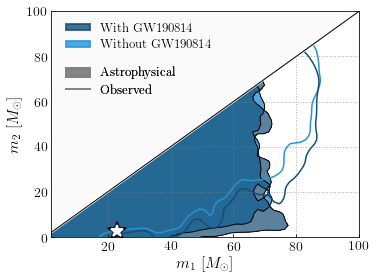

In [149]:
# Draw contours at these locations
fig,ax = plt.subplots(figsize=(5.33,4))

ax.contourf(x_gridpoints,y_gridpoints,z_grid_no190814,levels=(val99_no190814,np.inf),colors="#2592db",alpha=0.8)
ax.contour(x_gridpoints,y_gridpoints,z_grid_no190814,levels=(val99_no190814,),colors="black",linewidths=1)

ax.contourf(x_gridpoints,y_gridpoints,z_grid_w190814,levels=(val99_w190814,np.inf),colors="#154d73",alpha=0.7)
ax.contour(x_gridpoints,y_gridpoints,z_grid_w190814,levels=(val99_w190814,),colors="black",linewidths=1)

ax.contour(x_gridpoints,y_gridpoints,z_grid_no190814_obs,levels=(val99_no190814_obs,),colors="#2592db",linewidths=1.5)
ax.contour(x_gridpoints,y_gridpoints,z_grid_w190814_obs,levels=(val99_w190814_obs,),colors="#154d73",linewidths=1.5)

ax.xaxis.grid(True,which='major',ls=':',color='grey')
ax.yaxis.grid(True,which='major',ls=':',color='grey')

ax.fill_between(np.linspace(2,100,100),np.linspace(2,100,100),100*np.ones(100),color='#fafafa',zorder=2)
ax.plot(np.linspace(2,100,100),np.linspace(2,100,100),color='black',lw=1)

ax.set_xlim(2,100)
ax.set_ylim(0,100)

handles1 = [Rectangle((0,0),1,1,color='#154d73',fill=True,lw=2,alpha=0.8),
          Rectangle((0,0),1,1,color='#2592db',fill=True,lw=2,alpha=0.8)]
labels1 = ["With GW190814","Without GW190814"]
legend1 = plt.legend(handles1,labels1,fontsize=13,frameon=False,labelspacing=0.3,loc=(0.03,0.8),handlelength=1.85,handleheight=0.3)

handles2 = [Rectangle((0,0),1,1,color='grey',fill=True,lw=2,alpha=0.8),
          Line2D((0,1),(1,1),color='grey',lw=2,alpha=0.8)]
labels2 = ["Astrophysical","Observed"]
legend2 = plt.legend(handles2,labels2,fontsize=13,frameon=False,labelspacing=0.3,loc=(0.03,0.6),handlelength=1.85,handleheight=0.65)

# Save legend
ax.add_artist(legend1)
ax.add_artist(legend2)

ax.plot(22.9,2.6,marker='*', markersize=19, markeredgewidth=2, color="black")
ax.plot(22.9,2.6,marker='*', markersize=12, markeredgewidth=2, color="white")

ax.set_xlabel(r'$m_1 \ [M_\odot]$')
ax.set_ylabel(r'$m_2 \ [M_\odot]$')

plt.tight_layout()
plt.savefig("Production-Figures/m1m2_powerlaw_peak.pdf",bbox_inches='tight')
plt.show()

---
## Fig 21b: Marginal m1 Distributions

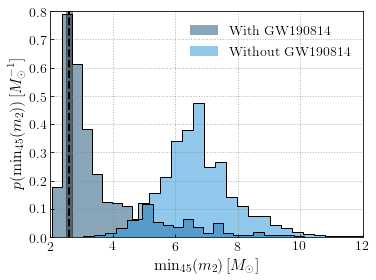

In [69]:
# Loop across catalog instantiations
min_m2_samples_w190814 = []
min_m2_samples_no190814 = []
for i in range(5000):
    
    # Get secondary masses
    samples_w190814 = synthetic_w190814['mass_2'].T[i]
    samples_no190814 = synthetic_no190814['mass_2'].T[i]

    # Read off minimum secondary mass across all events in catalog
    min_m2_samples_w190814.append(np.min(samples_w190814))
    min_m2_samples_no190814.append(np.min(samples_no190814)) 

fig,ax = plt.subplots(figsize=(5.33,4))

plt.hist(min_m2_samples_w190814,bins=40,histtype='step',
         density=True,color="black"
        )
plt.hist(min_m2_samples_w190814,bins=40,histtype='stepfilled',
         density=True,color="#154d73",
         alpha=0.5,rwidth=0.95,label='With GW190814'
        )

plt.hist(min_m2_samples_no190814,bins=40,histtype='step',
         density=True,color="black"
        )
plt.hist(min_m2_samples_no190814,bins=40,histtype='stepfilled',
         density=True,color="#2592db",linewidth=3,
         alpha=0.5,rwidth=0.95,label='Without GW190814'
        )

y1 = np.linspace(0,0.8,3)
x1 = np.array([2.6,2.6,2.6])
plt.plot(x1,y1, linestyle='dashed',linewidth=2, color='black')
plt.axvspan(2.5, 2.7, alpha=0.4, color='black')

ax.xaxis.grid(True,which='major',ls=':',color='grey')
ax.yaxis.grid(True,which='major',ls=':',color='grey')
plt.ylabel(r'$p(\mathrm{min}_{45}(m_2))\, [M_\odot^{-1}]$')
plt.xlabel(r'$\mathrm{min}_{45}(m_2) \, [M_\odot]$')
plt.xlim(2,12)
plt.ylim(0,0.8)
plt.legend(frameon=False,fontsize=14)
plt.tight_layout()
plt.savefig('./Production-Figures/minimum_m2_with_without_190814.pdf',bbox_inches='tight')
plt.show()

---
## Fig 23: Default Spin Corner Plot
#### Updated July 15, 2020

xi_spin mu_chi 0.024987993256146267
xi_spin sigma_chi 0.02147778052023691
xi_spin sigma_spin 0.04033028708191629
mu_chi sigma_chi 0.010554671829942332
mu_chi sigma_spin 0.01981922408397409
sigma_chi sigma_spin 0.01703509924120404


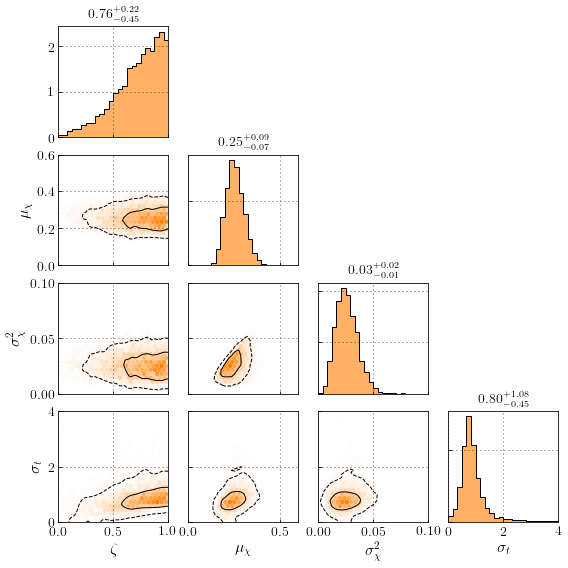

In [50]:
with open("../Population_Samples/default/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_result.json","r") as jfile:
    jf = json.load(jfile)
    
posterior_samples = jf['posterior']['content']

test_data = {
    'xi_spin':{'data':posterior_samples['xi_spin'],'plot_bounds':(0.,1.),'priors':(0.,1.),'label':r'$\zeta$'},
    'mu_chi':{'data':posterior_samples['mu_chi'],'plot_bounds':(0.,0.6),'priors':(0.,1.),'label':r'$\mu_\chi$'},
    'sigma_chi':{'data':posterior_samples['sigma_chi'],'plot_bounds':(0.,0.1),'priors':(0.,.25),'label':r'$\sigma^2_\chi$'},
    'sigma_spin':{'data':posterior_samples['sigma_spin'],'plot_bounds':(0.,4.),'priors':(0.,4.),'label':r'$\sigma_t$'}
}

fig = plt.figure(figsize=(8,8))
plot_corner(fig,test_data,"#ff7f00",bins=25,hist_alpha=0.6)

#for ax in fig.axes:
#    ax.set_rasterization_zorder(1)

plt.tight_layout()
fig.subplots_adjust(wspace=0.18, hspace=0.16)
fig.savefig('./Production-Figures/corner_defaultSpin.pdf',dpi=100)
plt.show()

---
## Fig 24a: Chi-Effective PPD comparison

findfont: Font family ['Serif'] not found. Falling back to DejaVu Sans.


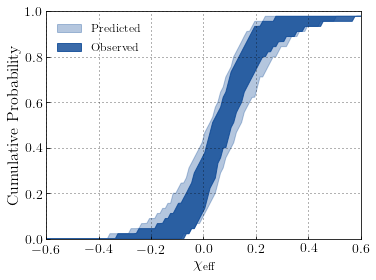

In [51]:
with open('./Multiple-Fig-Data/effective_spin_ppd/gaussian-spin-xeff-xp-ppcheck-data.json','r') as jf:
    ppc_data = json.load(jf)
    
chi_eff_grid = ppc_data['CDFs']['chi_eff_grid']
synthetic_chiEff_counts = ppc_data['CDFs']['synthetic_chi_eff_counts']
observed_chiEff_counts = ppc_data['CDFs']['observed_chi_eff_counts']

fig,ax = plt.subplots(figsize=(5.33,4))

ax.fill_between(chi_eff_grid,np.quantile(synthetic_chiEff_counts,0.95,axis=1)/45.,np.quantile(synthetic_chiEff_counts,0.05,axis=1)/45.,
               color='#084594',alpha=0.3,label='Predicted')

ax.fill_between(chi_eff_grid,np.quantile(observed_chiEff_counts,0.95,axis=1)/45.,np.quantile(observed_chiEff_counts,0.05,axis=1)/45.,
               color='#084594',alpha=0.8,label='Observed')

ax.set_xlim(-0.6,0.6)
ax.set_ylim(0,1)
ax.grid(True,dashes=(1,3))
ax.set_xlabel(r'$\chi_\mathrm{eff}$')
ax.set_ylabel(r'Cumulative Probability')
plt.legend(loc='upper left',frameon=False,fontsize=12)
plt.tight_layout()
plt.savefig('Production-Figures/chi-eff-ppc.pdf',bbox_inches='tight')
plt.show()

---
## Fig 24b: Chi-P PPD comparison

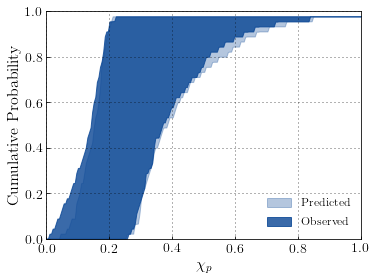

In [52]:
with open('./Multiple-Fig-Data/effective_spin_ppd/gaussian-spin-xeff-xp-ppcheck-data.json','r') as jf:
    ppc_data = json.load(jf)
    
chi_p_grid = ppc_data['CDFs']['chi_p_grid']
synthetic_chiP_counts = ppc_data['CDFs']['synthetic_chi_p_counts']
observed_chiP_counts = ppc_data['CDFs']['observed_chi_p_counts']

fig,ax = plt.subplots(figsize=(5.33,4))

ax.fill_between(chi_p_grid,np.quantile(synthetic_chiP_counts,0.95,axis=1)/45.,np.quantile(synthetic_chiP_counts,0.05,axis=1)/45.,
               color='#084594',alpha=0.3,label='Predicted')

ax.fill_between(chi_p_grid,np.quantile(observed_chiP_counts,0.95,axis=1)/45.,np.quantile(observed_chiP_counts,0.05,axis=1)/45.,
               color='#084594',alpha=0.8,label='Observed')

ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.grid(True,dashes=(1,3))
ax.set_xlabel(r'$\chi_p$')
ax.set_ylabel(r'Cumulative Probability')
plt.legend(loc='lower right',frameon=False,fontsize=12)
plt.tight_layout()
plt.savefig('Production-Figures/chi-p-ppc.pdf',bbox_inches='tight')
plt.show()

---
## Fig 25: Chi-Effective-Min Posterior

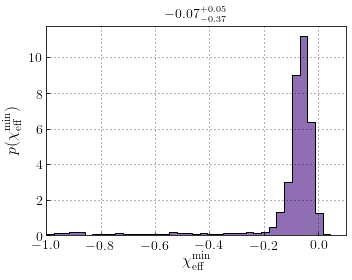

In [93]:
color_gaussian = "#6a3d9a"
datafile = "../Population_Samples/gaussian-spin/gaussian-chiEff-variable-chiMin-samples.json"
with open(datafile,'r') as jf:
    samples = json.load(jf)

plot_data = {
    'xi_min':{'data':samples['chi_eff_min'],'plot_bounds':(-1.0,0.1),'priors':(-1.0,0.1),'label':r'$\chi^\mathrm{min}_\mathrm{eff}$'}
}

fig = plt.figure(figsize=(5,4))
plot_corner(fig,plot_data,"#6a3d9a",bins=40,hist_alpha=0.75)
fig.gca().set_ylabel(r"$p(\chi^\mathrm{min}_\mathrm{eff})$")
plt.tight_layout()
fig.savefig('./Production-Figures/chi_eff_min.pdf',dpi=200)
plt.show()

---
## Fig 26: Redshift PPC

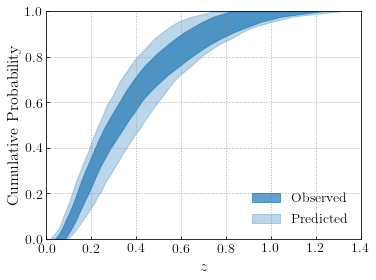

In [54]:
h5data = h5py.File("Fig-26-redshift-ppc/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_full_posterior.hdf5","r")
data = h5data["samples"][:]
events = [event.decode() for event in h5data["events"]]
data_frame = pd.DataFrame()
for name in data.dtype.names:
    data_frame[name] = data[name]

synthetic = np.array([
        data[f"synthetic_redshift_{ii}"] for ii in range(len(events))
        ])

observed = np.array([
        data[f"{name}_redshift"] for name in events
        ])

fig,ax = plt.subplots(figsize=(5.33,4))

ax.xaxis.grid(True,which='major',ls=':',color='grey')
ax.yaxis.grid(True,which='major',ls=':',color='grey')
ax.set_xlabel("$z$",fontsize=16)
ax.set_ylabel("Cumulative Probability",fontsize=16)

# Fill horizontally across the m1 range typically occupied by the i-th catalog event
ax.fill_betweenx(y = np.linspace(0,1,len(observed[:,0])),
                x1 = np.quantile(np.sort(observed,axis=0),0.05,axis=1),
                x2 = np.quantile(np.sort(observed,axis=0),0.95,axis=1),
                color = "#1f78b4", alpha=0.7, label='Observed'
                )

ax.fill_betweenx(y = np.linspace(0,1,len(synthetic[:,0])),
                x1 = np.quantile(np.sort(synthetic,axis=0),0.05,axis=1),
                x2 = np.quantile(np.sort(synthetic,axis=0),0.95,axis=1),
                color = "#1f78b4", alpha=0.3, label='Predicted'
                )

ax.legend(loc='lower right',frameon=False,fontsize=14)

ax.set_xlim(0,1.4)
ax.set_ylim(0,1)

plt.tight_layout()
plt.savefig('./Production-Figures/redshift-ppcheck.pdf',bbox_inches='tight')
plt.show()

---
## Scratch

mu_eff sigma_eff 0.008045074931152954
mu_eff mu_p 0.010966202825575306
mu_eff sigma_p 0.01025836167756477
mu_eff cov 0.022547631437570277
sigma_eff mu_p 0.017312035153355977
sigma_eff sigma_p 0.016194586294141815
sigma_eff cov 0.035595309906339696
mu_p sigma_p 0.022074762447537564
mu_p cov 0.04851979520546117
sigma_p cov 0.04538796296728917


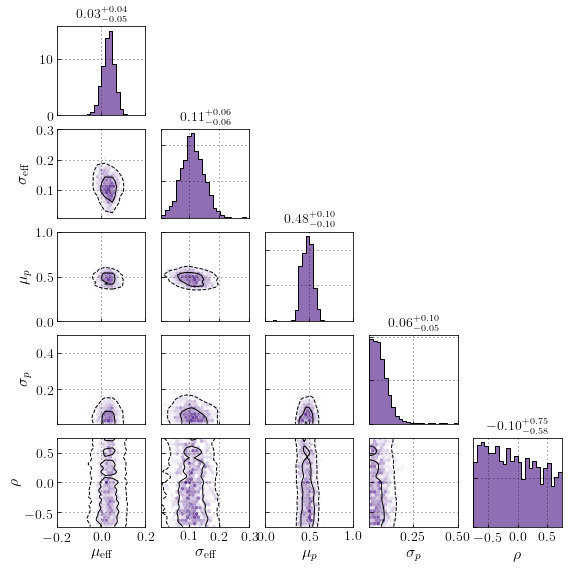

In [55]:
data = np.load('/home/thomas.callister/Simona/o3a-spin-studies/ChiEff-ChiP/processed_emcee_samples_shanika_2020-04-13_bespokePrior_newSel.npy')

plot_data = {
    'mu_eff':{'data':data[:,0],'plot_bounds':(-0.2,0.2),'priors':(-1.0,1.0),'label':r'$\mu_\mathrm{eff}$'},
    'sigma_eff':{'data':data[:,1],'plot_bounds':(0.01,0.3),'priors':(0.01,1.0),'label':r'$\sigma_\mathrm{eff}$'},
    'mu_p':{'data':data[:,2],'plot_bounds':(0.,1.),'priors':(0.,1.0),'label':r'$\mu_p$'},
    'sigma_p':{'data':data[:,3],'plot_bounds':(0.01,0.5),'priors':(0.01,1.0),'label':r'$\sigma_p$'},
    'cov':{'data':data[:,4],'plot_bounds':(-0.75,0.75),'priors':(-0.75,0.75),'label':r'$\rho$'}
}

fig = plt.figure(figsize=(8,8))
plot_corner(fig,plot_data,"#6a3d9a",bins=25,hist_alpha=0.75)
plt.tight_layout()
fig.subplots_adjust(wspace=0.18, hspace=0.16)
#fig.savefig('./Production-Figures/chi_eff_min.pdf',dpi=400)
plt.show()